# Steam Games Insight Engine - Complete Analysis Pipeline

This notebook provides an interactive interface to analyze Steam game reviews through multiple stages:
1. **Game Lookup** - Find games by name or ID
2. **Web Scraping** - Collect reviews from Steam
3. **Data Cleaning** - Prepare and standardize data
4. **Credibility Detection** - Filter fake/spam reviews
5. **ABSA** - Aspect-based sentiment analysis
6. **Emotion Analysis** - Ensemble emotion classification

## Setup

Run this notebook from the `Final Pipeline` directory.

In [1]:
# Imports and setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path for new structure
sys.path.append(str(Path.cwd() / "src"))

# Import pipeline components
from pipeline_utils import (
    SteamGameLookup, 
    DataCleaner, 
    CredibilityFilter,
    ABSAAnalyzer,
    EmotionAnalyzer
)

# For displaying images in notebook
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Configure notebook display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

# Analysis Configuration
ANALYSIS_CONFIG = {
    'overwrite_previous': True,     # Clean overwrite vs timestamped files
    'keep_backup': True,           # Backup previous analysis before overwrite
    'testing_mode': True           # Use subset of data for faster testing
}

print("✅ Pipeline components loaded successfully!")
print(f"📋 Config: {'Overwrite mode' if ANALYSIS_CONFIG['overwrite_previous'] else 'Timestamp mode'}")
print(f"🔧 Testing mode: {'ON' if ANALYSIS_CONFIG['testing_mode'] else 'OFF'}")

✅ Pipeline components loaded successfully!
📋 Config: Overwrite mode
🔧 Testing mode: ON


## Step 1: Game Selection

Enter either a Steam game ID or game name in lỉne 2 to begin analysis.

In [2]:
# Enter your game here (ID or name)
GAME_INPUT = "Coffee Talk"  # Change this to your desired game

# Initialize game lookup
game_lookup = SteamGameLookup()

# Search for game
if GAME_INPUT.isdigit():
    # Direct ID lookup
    game_info = game_lookup.validate_game_id(int(GAME_INPUT))
    if game_info:
        print(f"✅ Found game: {game_info['name']} (ID: {game_info['id']})")
    else:
        print("❌ Invalid game ID")
else:
    # Search by name
    print(f"🔍 Searching for '{GAME_INPUT}'...")
    search_results = game_lookup.search_games(GAME_INPUT, max_results=5)
    
    if search_results:
        print(f"\nFound {len(search_results)} games:")
        for i, game in enumerate(search_results, 1):
            print(f"{i}. {game['name']} ({game['release_date']}) - ID: {game['id']}")
        
        # Use first result automatically (or modify to ask for input)
        game_info = game_lookup.validate_game_id(search_results[0]['id'])
        print(f"\n✅ Selected: {game_info['name']} (ID: {game_info['id']})")
    else:
        print("❌ No games found")
        game_info = None

🔍 Searching for 'Coffee Talk'...

Found 5 games:
1. Coffee Talk (Jan 29, 2020) - ID: 914800
2. Coffee Talk Tokyo (2025) - ID: 3161220
3. Coffee Talk Episode 2: Hibiscus & Butterfly (Apr 20, 2023) - ID: 1663220
4. Afterlove EP (Feb 14, 2025) - ID: 1599780
5. Noun Town Language Learning (Nov 2, 2023) - ID: 2313720

✅ Selected: Coffee Talk (ID: 914800)


## Step 2: Web Scraping

Scrape reviews from Steam. This may take several minutes depending on the number of reviews. The progress bar will show real-time status.

In [3]:
if game_info:
    # Web scraping Steam reviews using local module
    print("📁 Starting web scraping for Steam reviews...")
    
    # Import local web scraper wrapper
    from pipeline_utils.web_scraper import WebScraperWrapper
    
    print(f"🕷️ Starting review scraping for {game_info['name']}...")
    print("This may take a few minutes...")
    
    # Initialize scraper
    web_scraper = WebScraperWrapper()
    
    # Scrape reviews
    reviews_df = web_scraper.scrape_reviews(game_info['id'])
    
    if reviews_df is not None and len(reviews_df) > 0:
        print(f"\n✅ Successfully scraped {len(reviews_df)} reviews!")
        
        # TESTING MODE: Limit to first 1000 rows for faster processing
        if ANALYSIS_CONFIG['testing_mode'] and len(reviews_df) > 1000:
            print(f"🧪 TESTING MODE: Using first 1000 reviews (out of {len(reviews_df)})")
            reviews_df = reviews_df.head(1000).copy()
        
        print(f"\nDataset shape: {reviews_df.shape}")
        print(f"\nColumns: {list(reviews_df.columns)}")
        
        # Show sample
        print("\nSample reviews:")
        display(reviews_df.head())
        
        # Check minimum threshold
        if len(reviews_df) < 1000:
            print(f"\n❌ ERROR: Only {len(reviews_df)} reviews found. Minimum required is 1000.")
            print("⚠️  Analysis will not proceed with fewer than 1000 reviews.")
            reviews_df = None
        elif len(reviews_df) <= 2500:
            print(f"\n⚠️ Warning: Only {len(reviews_df)} reviews found.")
            print("📊 Results may be less accurate, especially after filtering fake reviews.")
            print("💡 Recommended: 2500+ reviews for robust analysis.")
        
        # Save raw data with clean naming
        if reviews_df is not None:
            game_id = game_info['id']
            game_outputs = Path(f"outputs/game_{game_id}")
            raw_data_dir = game_outputs / "data" / "raw"
            raw_data_dir.mkdir(parents=True, exist_ok=True)
            
            raw_file = raw_data_dir / "scraped_reviews.csv"
            
            # Handle backup if overwrite mode
            if ANALYSIS_CONFIG['overwrite_previous'] and raw_file.exists() and ANALYSIS_CONFIG['keep_backup']:
                backup_file = raw_data_dir / f"scraped_reviews_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
                raw_file.rename(backup_file)
                print(f"📋 Previous raw data backed up to {backup_file.name}")
            
            reviews_df.to_csv(raw_file, index=False)
            print(f"💾 Raw reviews saved to: {raw_file}")
    else:
        print("❌ Failed to scrape reviews")
        reviews_df = None

📁 Starting web scraping for Steam reviews...
🕷️ Starting review scraping for Coffee Talk...
This may take a few minutes...


Scraping reviews:   0%|          | 0/4282 [00:00<?, ?reviews/s]


📊 Filtering results:
   Total reviews processed: 4056
   English reviews after filtering: 3571
   Filtered out: 485 reviews (12.0%)

✅ Successfully scraped 3571 reviews!
🧪 TESTING MODE: Using first 1000 reviews (out of 3571)

Dataset shape: (1000, 12)

Columns: ['playtime_forever', 'num_games_owned', 'num_reviews', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'written_during_early_access', 'primarily_steam_deck', 'timestamp_created', 'review']

Sample reviews:


,playtime_forever,num_games_owned,num_reviews,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,written_during_early_access,primarily_steam_deck,timestamp_created,review
0,386,174,20,0,0,0.489972680807113647,0,True,False,False,2025-06-03 03:04:34,absolut ador stori behind game get move second one see pick hope would recommend game overal tha...
1,959,0,6,0,0,0.489972680807113647,0,True,False,False,2025-06-01 21:47:42,far stori driven game goe one favourit soundtrack great eclect combin differ patron give output ...
2,705,0,2,0,0,0.489972680807113647,0,True,False,False,2025-06-01 18:03:32,love everyth game
3,216,0,5,0,0,0.489972680807113647,0,True,False,False,2025-05-31 16:40:55,one favorit visual novel incred good stori charact develop mmmm cofe
4,776,60,2,0,0,0.489972680807113647,0,True,False,False,2025-05-30 19:19:35,one favorit game vibe awesom charact stori relat rest show new thing peopl may never experienc l...



⚠️ Warning: Only 1000 reviews found.
📊 Results may be less accurate, especially after filtering fake reviews.
💡 Recommended: 2500+ reviews for robust analysis.
📋 Previous raw data backed up to scraped_reviews_backup_20250605_021754.csv
💾 Raw reviews saved to: outputs\game_914800\data\raw\scraped_reviews.csv


## Step 3: Model Downloading

Download fine-tuned models from Google Drive.

In [4]:
# Setup: Download emotion models if needed
# Only run this cell if you get "models not found" errors below

import os
import zipfile
import tempfile
from pathlib import Path
from tqdm import tqdm

def setup_emotion_models():
    """Download and setup emotion models from Google Drive"""
    
    # Install gdown if needed
    try:
        import gdown
    except ImportError:
        print("📦 Installing gdown...")
        os.system("pip install gdown")
        import gdown
    
    # Check if models already exist in the new location
    models_dir = Path("models")
    
    models = ["gpt2", "roberta", "deberta"]
    missing_models = []
    
    print("🔍 Checking existing models...")
    for model in models:
        model_file = models_dir / model / "final_model.pt"
        if model_file.exists():
            print(f"✅ {model}: Found")
        else:
            print(f"❌ {model}: Missing")
            missing_models.append(model)
    
    if not missing_models:
        print("\n✅ All models already installed!")
        return True
    
    print(f"\n📥 Downloading models from Google Drive...")
    print("📦 Archive size: ~4.1 GB (this may take 10-15 minutes)")
    
    # Google Drive file ID
    file_id = "1JVKU6n-yGC_s1lA68o208kw9RqlMJhb8"
    
    # Download and extract
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)
        archive_path = temp_dir / "models.zip"
        
        try:
            # Download
            print("⬇️  Starting download...")
            gdown.download(id=file_id, output=str(archive_path), quiet=False)
            
            if not archive_path.exists():
                print("❌ Download failed!")
                return False
            
            print(f"✅ Download complete! ({archive_path.stat().st_size / 1e9:.1f} GB)")
            
            # Extract to local models directory
            print("📦 Extracting models...")
            models_dir.mkdir(parents=True, exist_ok=True)
            
            with zipfile.ZipFile(archive_path, 'r') as zip_ref:
                for file_info in tqdm(zip_ref.infolist(), desc="Extracting"):
                    if file_info.filename.endswith(('.pt', '.json')):
                        # Extract to local models directory
                        # Convert from checkpoints/model/file.pt to models/model/file.pt
                        if 'checkpoints/' in file_info.filename:
                            new_path = file_info.filename.replace('checkpoints/', '')
                            target_path = models_dir / new_path
                            target_path.parent.mkdir(parents=True, exist_ok=True)
                            
                            with zip_ref.open(file_info) as source, open(target_path, 'wb') as target:
                                target.write(source.read())
            
            print("✅ Extraction complete!")
            
            # Verify
            all_good = True
            print("\n🔍 Verifying installation:")
            for model in models:
                model_file = models_dir / model / "final_model.pt"
                if model_file.exists():
                    print(f"✅ {model}: Installed")
                else:
                    print(f"❌ {model}: Failed")
                    all_good = False
            
            if all_good:
                print("\n🎉 All models successfully installed to local models/ directory!")
                return True
            else:
                print("\n❌ Some models failed to install")
                return False
                
        except Exception as e:
            print(f"❌ Error during setup: {e}")
            return False

# Run setup if models are missing
print("🚀 Emotion Model Setup (Local)")
print("=" * 40)
setup_emotion_models()

🚀 Emotion Model Setup (Local)
🔍 Checking existing models...
✅ gpt2: Found
✅ roberta: Found
✅ deberta: Found

✅ All models already installed!


True

## Step 4: Data Cleaning

Clean and prepare the scraped data for analysis.

🧹 Cleaning review data...

✅ Data cleaning complete!

Data Summary:
- Total reviews: 1000
- Avg playtime: 9.5 hours
- Median playtime: 7.5 hours
- Avg review length: 178 characters
- Reviews with upvotes: 258


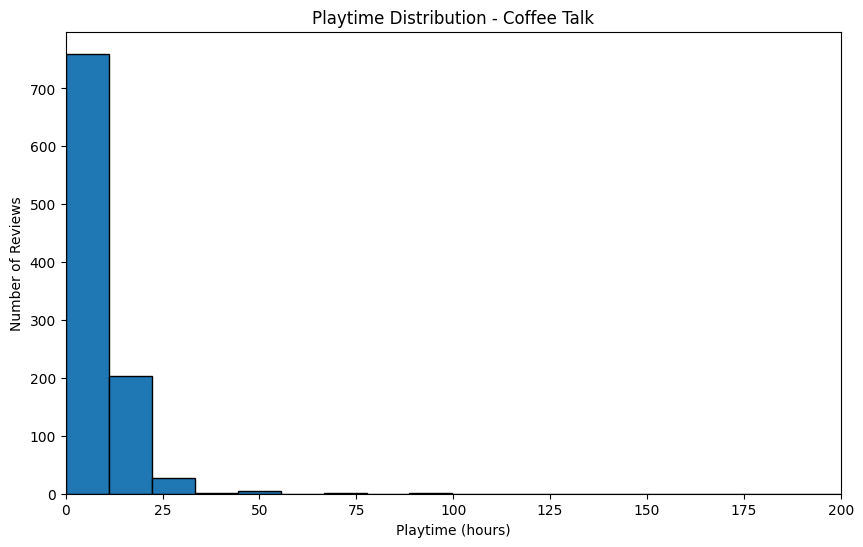

In [5]:
if reviews_df is not None:
    # Initialize cleaner
    cleaner = DataCleaner()
    
    print("🧹 Cleaning review data...")
    
    # Clean reviews
    cleaned_df = cleaner.clean_reviews(reviews_df)
    
    # Get summary
    summary = cleaner.get_data_summary(cleaned_df)
    
    print(f"\n✅ Data cleaning complete!")
    print(f"\nData Summary:")
    print(f"- Total reviews: {summary['total_reviews']}")
    print(f"- Avg playtime: {summary['avg_playtime_hours']:.1f} hours")
    print(f"- Median playtime: {summary['median_playtime_hours']:.1f} hours")
    print(f"- Avg review length: {summary['avg_review_length']:.0f} characters")
    print(f"- Reviews with upvotes: {summary['reviews_with_votes']}")
    
    # Show playtime distribution
    plt.figure(figsize=(10, 6))
    plt.hist(cleaned_df['playtime_forever'] / 60, bins=50, edgecolor='black')
    plt.xlabel('Playtime (hours)')
    plt.ylabel('Number of Reviews')
    plt.title(f'Playtime Distribution - {game_info["name"]}')
    plt.xlim(0, 200)  # Focus on 0-200 hours
    plt.show()

## Step 5: Credibility Detection

Filter out fake or spam reviews using enhanced y3 rules with KNN.

In [6]:
if 'cleaned_df' in locals():
    # Initialize credibility filter
    cred_filter = CredibilityFilter()
    
    print("🔍 Running credibility detection...")
    
    # Filter reviews
    credible_df, fake_df = cred_filter.filter_reviews(cleaned_df, use_knn=True)
    
    print(f"\n✅ Credibility filtering complete!")
    print(f"\nResults:")
    print(f"- Credible reviews: {len(credible_df)} ({len(credible_df)/len(cleaned_df)*100:.1f}%)")
    print(f"- Fake reviews: {len(fake_df)} ({len(fake_df)/len(cleaned_df)*100:.1f}%)")
    
    # Check if too many reviews were filtered
    fake_rate = len(fake_df) / len(cleaned_df)
    if fake_rate > 0.1:  # More than 10% fake
        print(f"\n⚠️ HIGH FAKE RATE WARNING: {fake_rate:.1%} of reviews were flagged as fake!")
        print("📊 This may indicate:")
        print("   - Review manipulation/botting for this game")
        print("   - Overly aggressive filtering rules")
        print("   - Need for game-specific threshold adjustment")
    
    if len(credible_df) < 1000:
        print(f"\n⚠️ WARNING: Only {len(credible_df)} credible reviews remain after filtering!")
        print("📊 Results may be unreliable with this few reviews.")
        if len(cleaned_df) >= 1000:
            print(f"💡 Consider adjusting credibility thresholds (started with {len(cleaned_df)} reviews)")
    
    # Analyze fake reviews if any
    if len(fake_df) > 0:
        fake_summary = cred_filter.get_fake_review_summary(fake_df)
        print(f"\nFake Review Analysis:")
        print(f"- Avg playtime: {fake_summary['avg_playtime']:.1f} minutes")
        print(f"- Avg games owned: {fake_summary['avg_num_games']:.0f}")
        print(f"- Avg reviews written: {fake_summary['avg_num_reviews']:.0f}")
        print(f"- Avg upvotes: {fake_summary['avg_votes_up']:.1f}")
        
        # Show examples of fake reviews
        print("\nExample fake reviews:")
        display(fake_df[['playtime_forever', 'review', 'num_reviews', 'votes_up']].head())
    
    # Save credible reviews with clean naming
    if len(credible_df) > 0:
        game_id = game_info['id']
        game_outputs = Path(f"outputs/game_{game_id}")
        cleaned_dir = game_outputs / "data" / "cleaned"
        cleaned_dir.mkdir(parents=True, exist_ok=True)
        
        credible_file = cleaned_dir / "credible_reviews.csv"
        
        # Handle backup if overwrite mode
        if ANALYSIS_CONFIG['overwrite_previous'] and credible_file.exists() and ANALYSIS_CONFIG['keep_backup']:
            backup_file = cleaned_dir / f"credible_reviews_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            credible_file.rename(backup_file)
            print(f"\n📋 Previous credible data backed up to {backup_file.name}")
        
        credible_df.to_csv(credible_file, index=False)
        print(f"💾 Credible reviews saved to: {credible_file}")

🔍 Running credibility detection...

✅ Credibility filtering complete!

Results:
- Credible reviews: 914 (91.4%)
- Fake reviews: 86 (8.6%)

⚠️ WARNING: Only 914 credible reviews remain after filtering!
📊 Results may be unreliable with this few reviews.
💡 Consider adjusting credibility thresholds (started with 1000 reviews)

Fake Review Analysis:
- Avg playtime: 427.0 minutes
- Avg games owned: 388
- Avg reviews written: 103
- Avg upvotes: 0.0

Example fake reviews:


,playtime_forever,review,num_reviews,votes_up
7,125,realli want lofi version cyberpunk vahaa realli want like charact write didnt realli grab world ...,149,0
11,65,cant recommend game sadli get caught two seriou gameplay design choic bother lot need commit did...,71,0
17,192,short fun play realli got know feel charact,102,0
48,386,b near alreadi finish game feel give pretti good opinion b h good point h write charact drink di...,117,0
86,181,serv latenight coffe listen tale custom recommend sale visual novel dont expect much term gamepl...,78,0



📋 Previous credible data backed up to credible_reviews_backup_20250605_021754.csv
💾 Credible reviews saved to: outputs\game_914800\data\cleaned\credible_reviews.csv


## Step 6: Aspect-Based Sentiment Analysis (ABSA)

Analyze sentiments for different aspects of the game.


📊 Running Aspect-Based Sentiment Analysis...
This includes both keyword-based and topic modeling approaches...

Debug - Sample review texts:
1. absolut ador stori behind game get move second one see pick hope would recommend game overal thank c...
2. far stori driven game goe one favourit soundtrack great eclect combin differ patron give output othe...
3. love everyth game...


Analyzing reviews (Keyword ABSA):   0%|          | 0/914 [00:00<?, ?it/s]


✅ ABSA Analysis Complete!

Summary:
- Keyword aspects found: 6
- Topics discovered: 10
- Most mentioned: audio
- Most positive: audio
- Most negative: performance

Aspect Sentiment Breakdown:


,Aspect,Mentions,Positive %,Confidence
1,audio,197,61.7%,0.957
2,gameplay,184,56.9%,0.964
4,graphics,175,52.3%,0.952
0,content,74,40.0%,0.958
3,value,68,40.9%,0.945
5,performance,47,32.6%,0.929



📊 Aspect Sentiment Analysis:


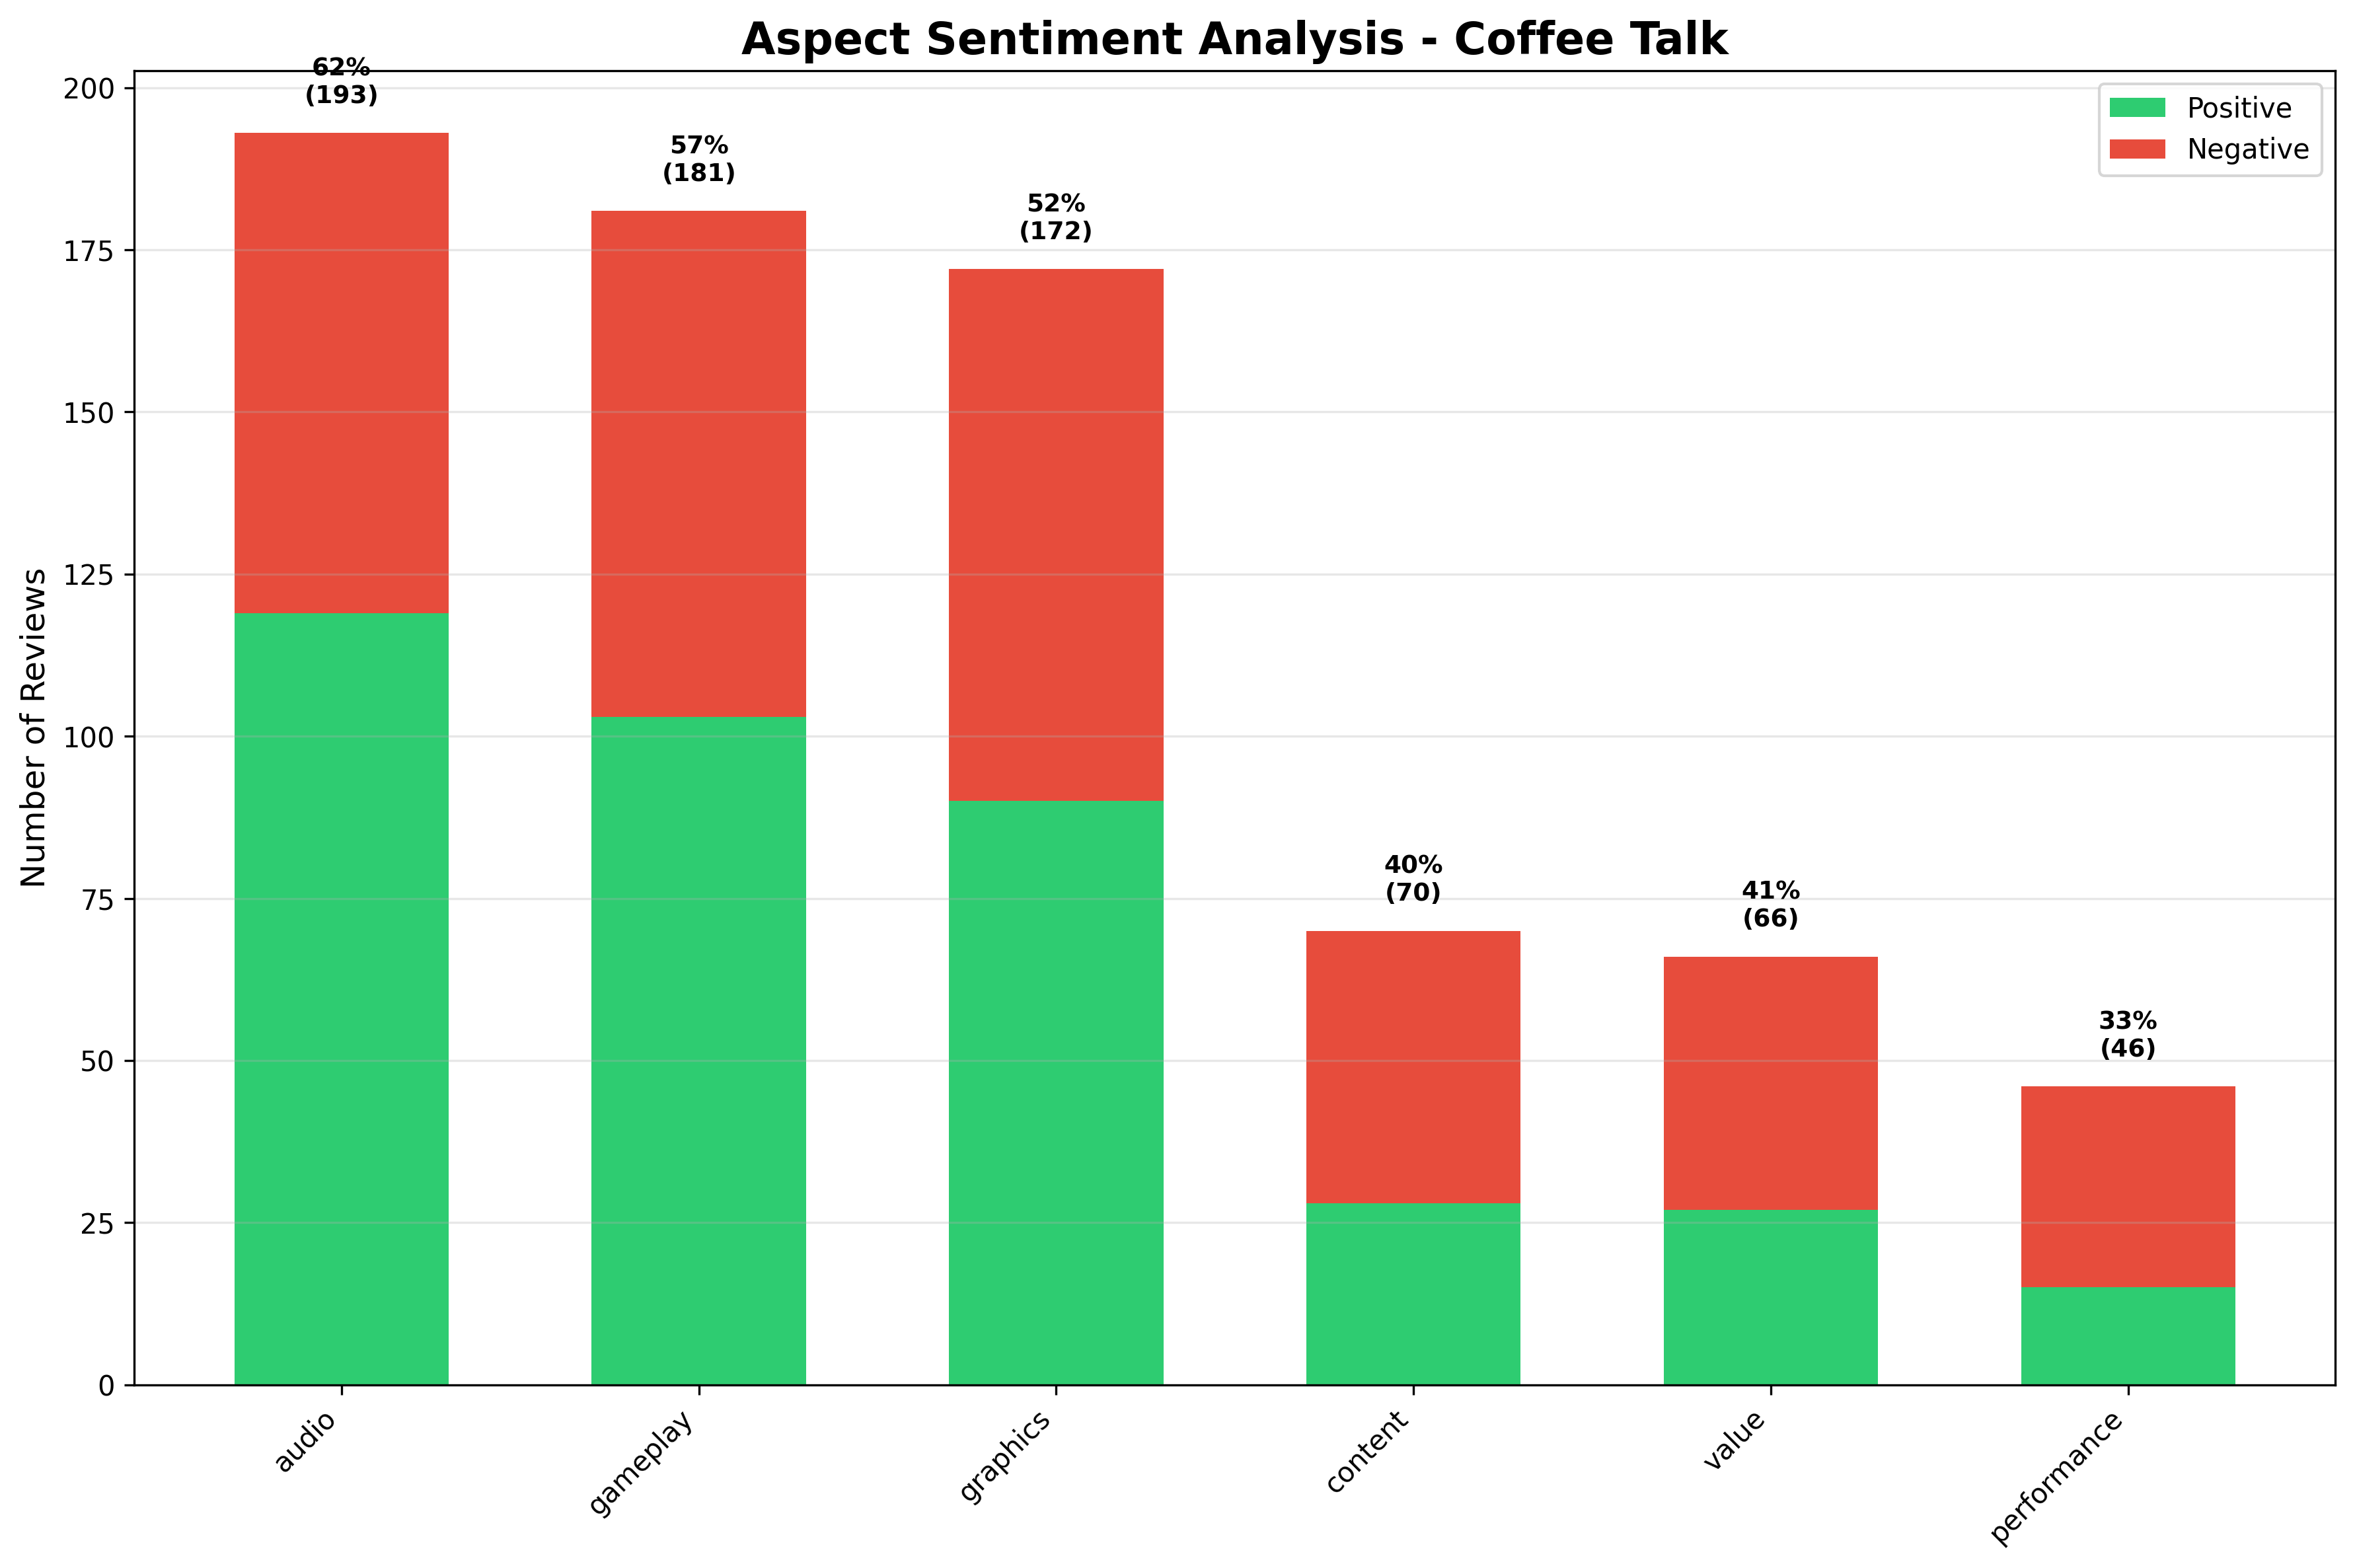


🥧 Overall Sentiment Distribution:


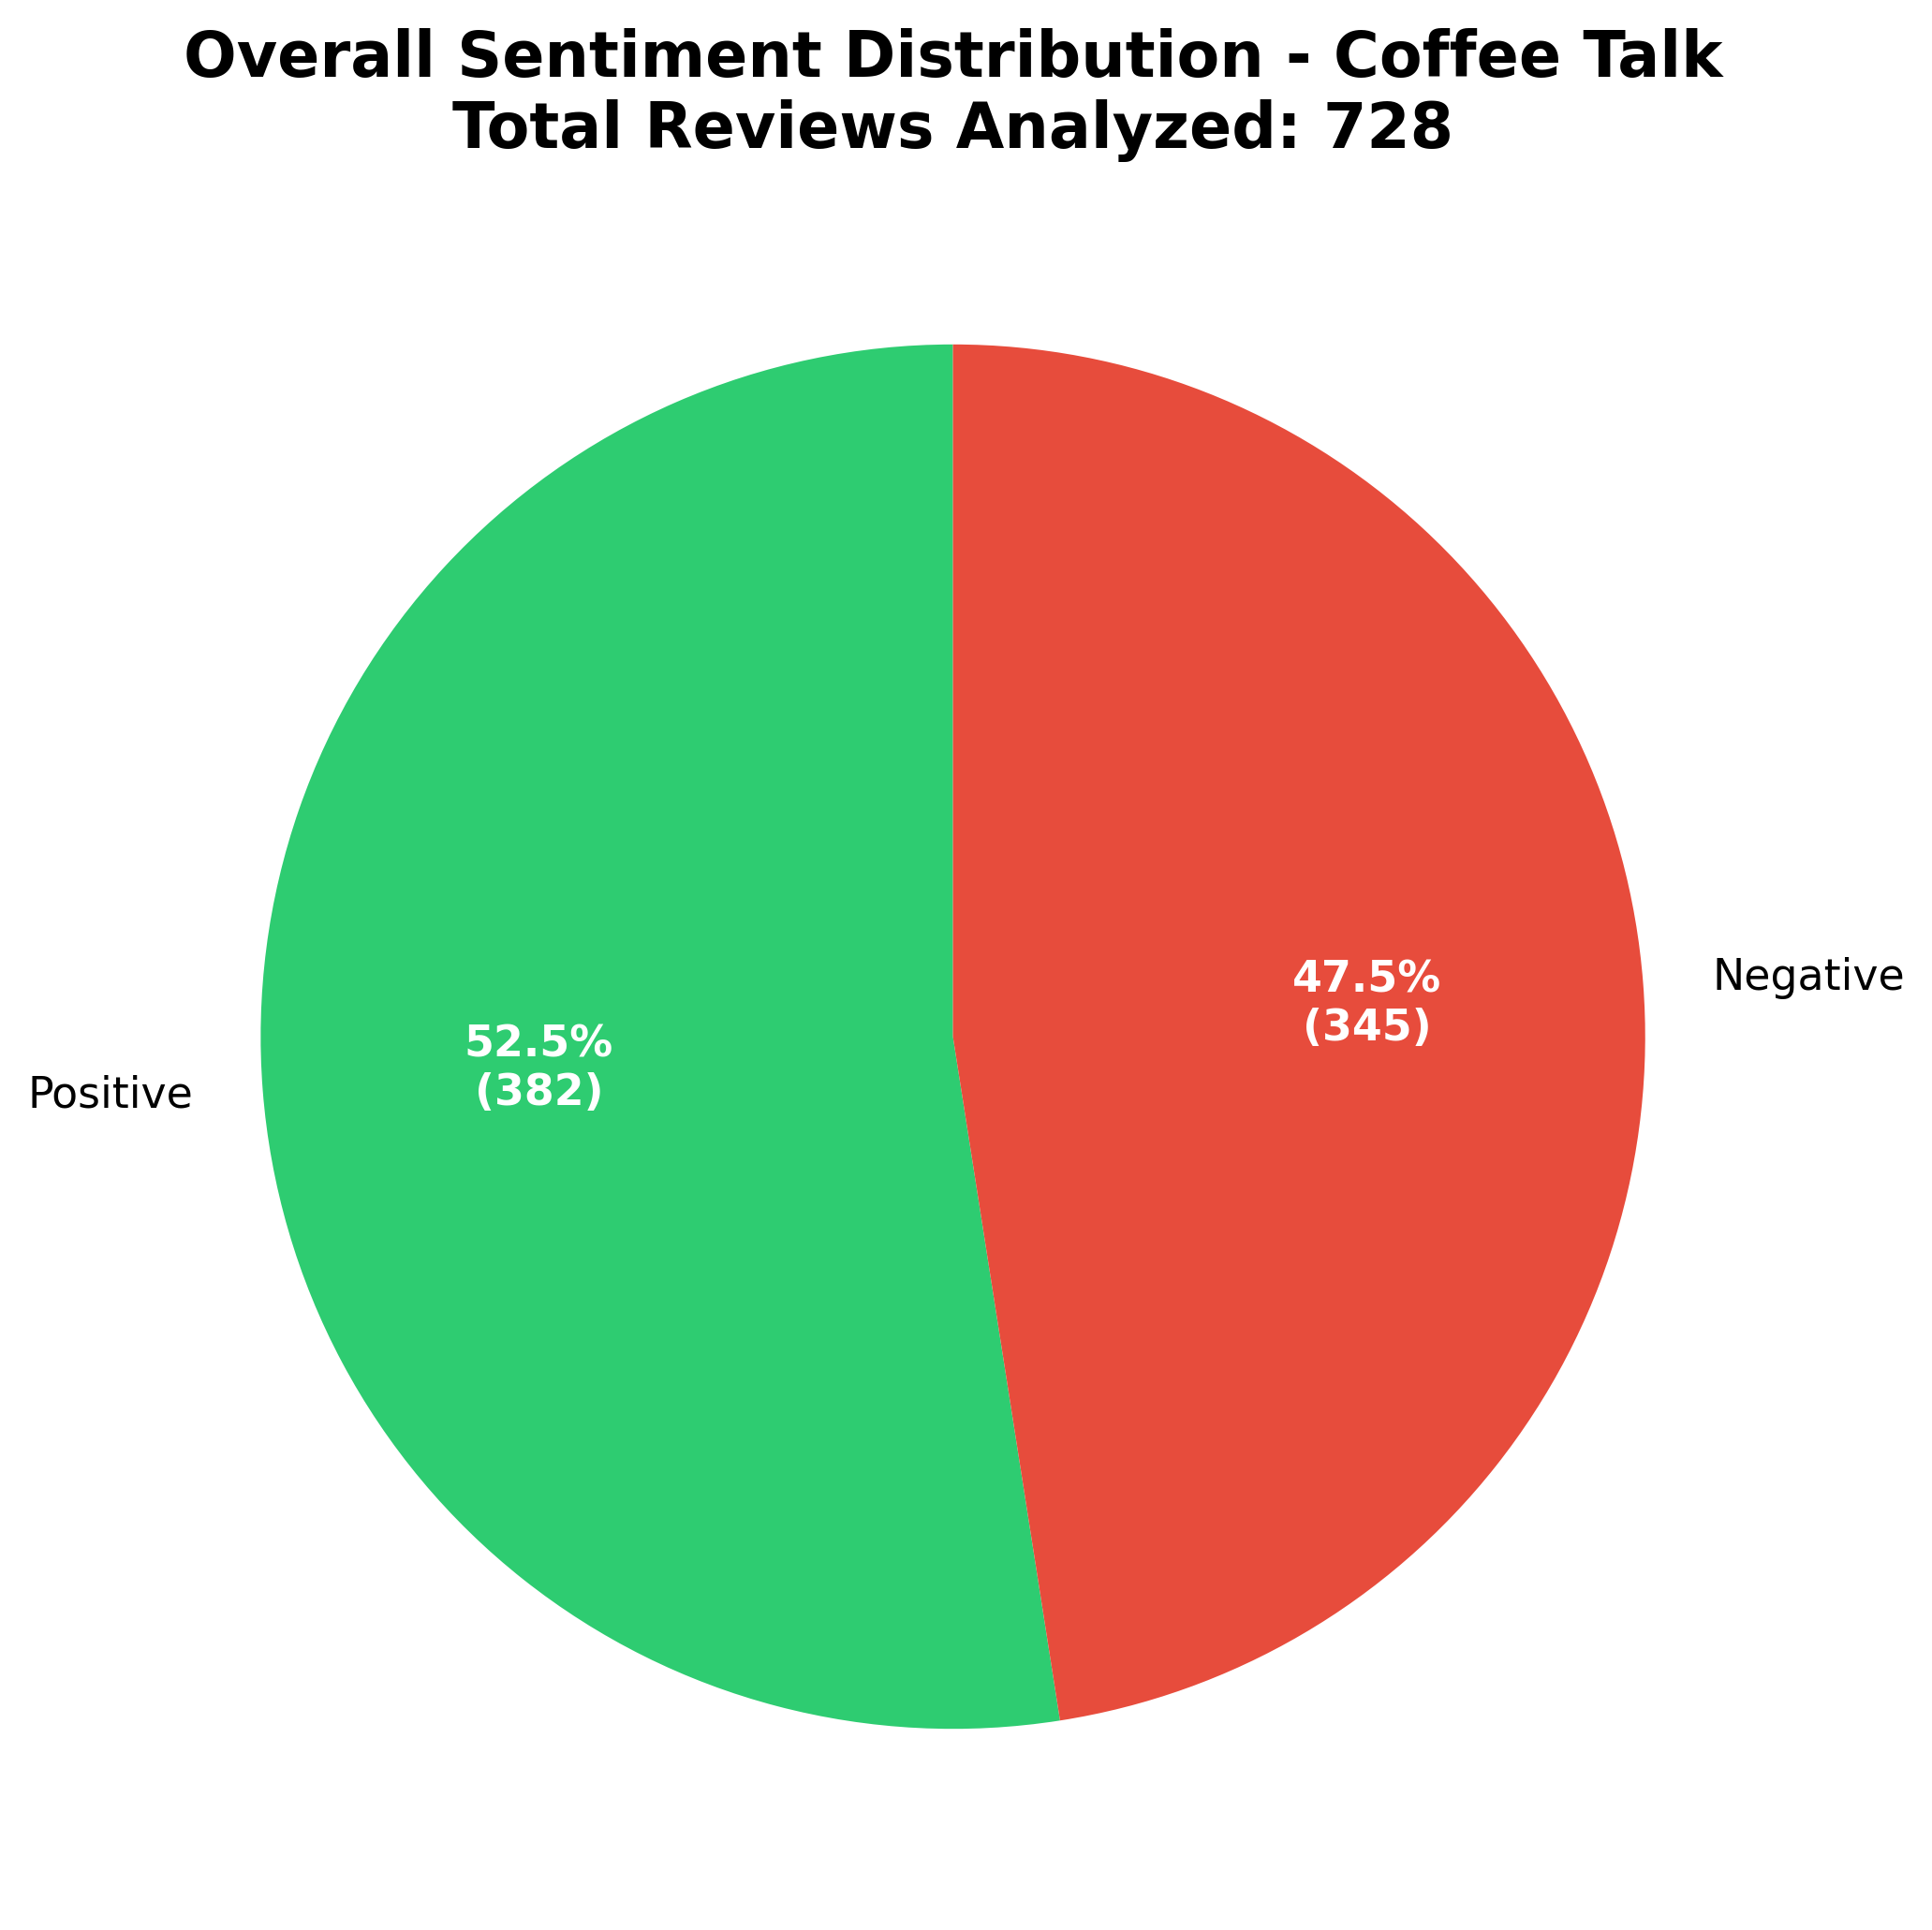


🔥 Aspect Analysis Heatmap:


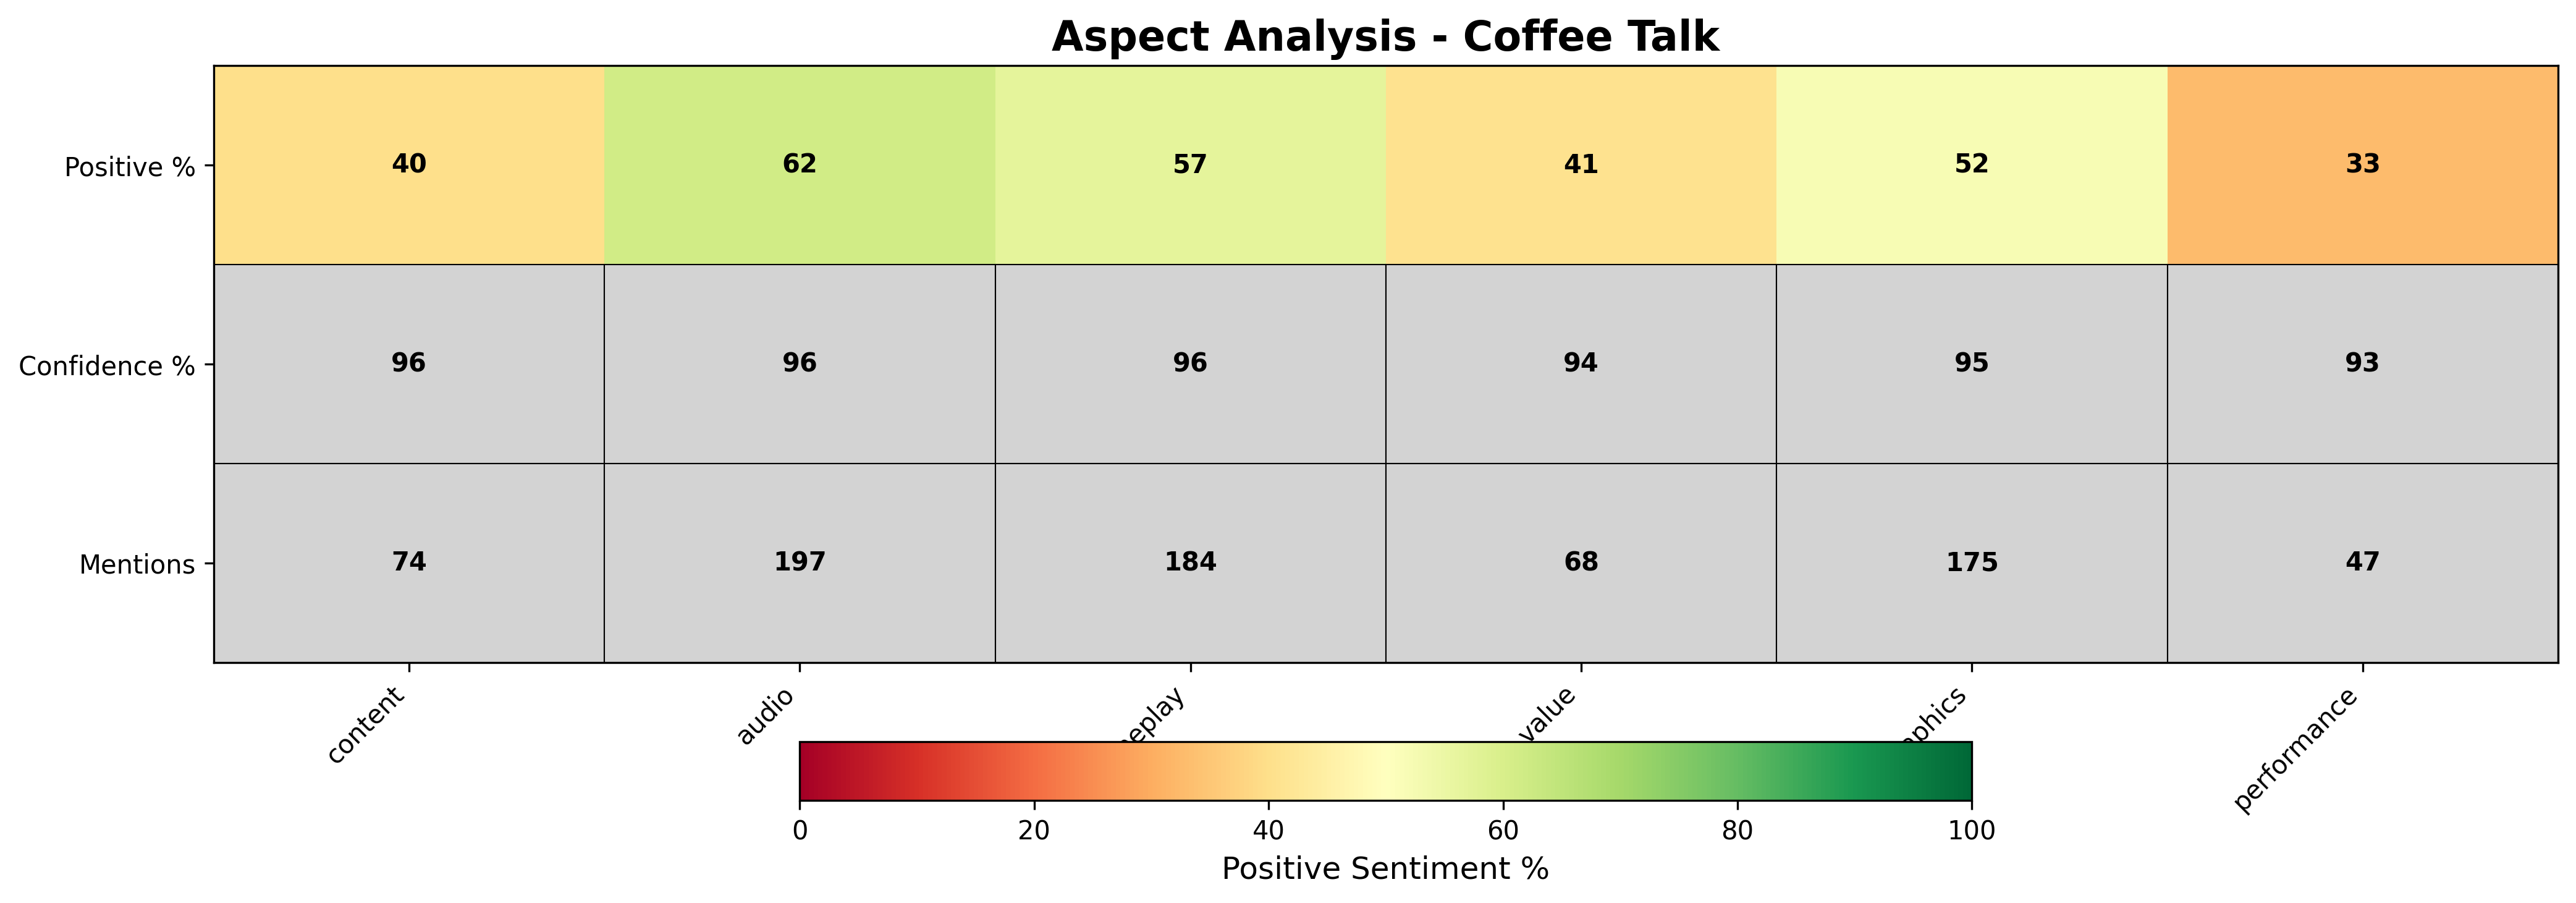


📈 ABSA Confidence Distribution:


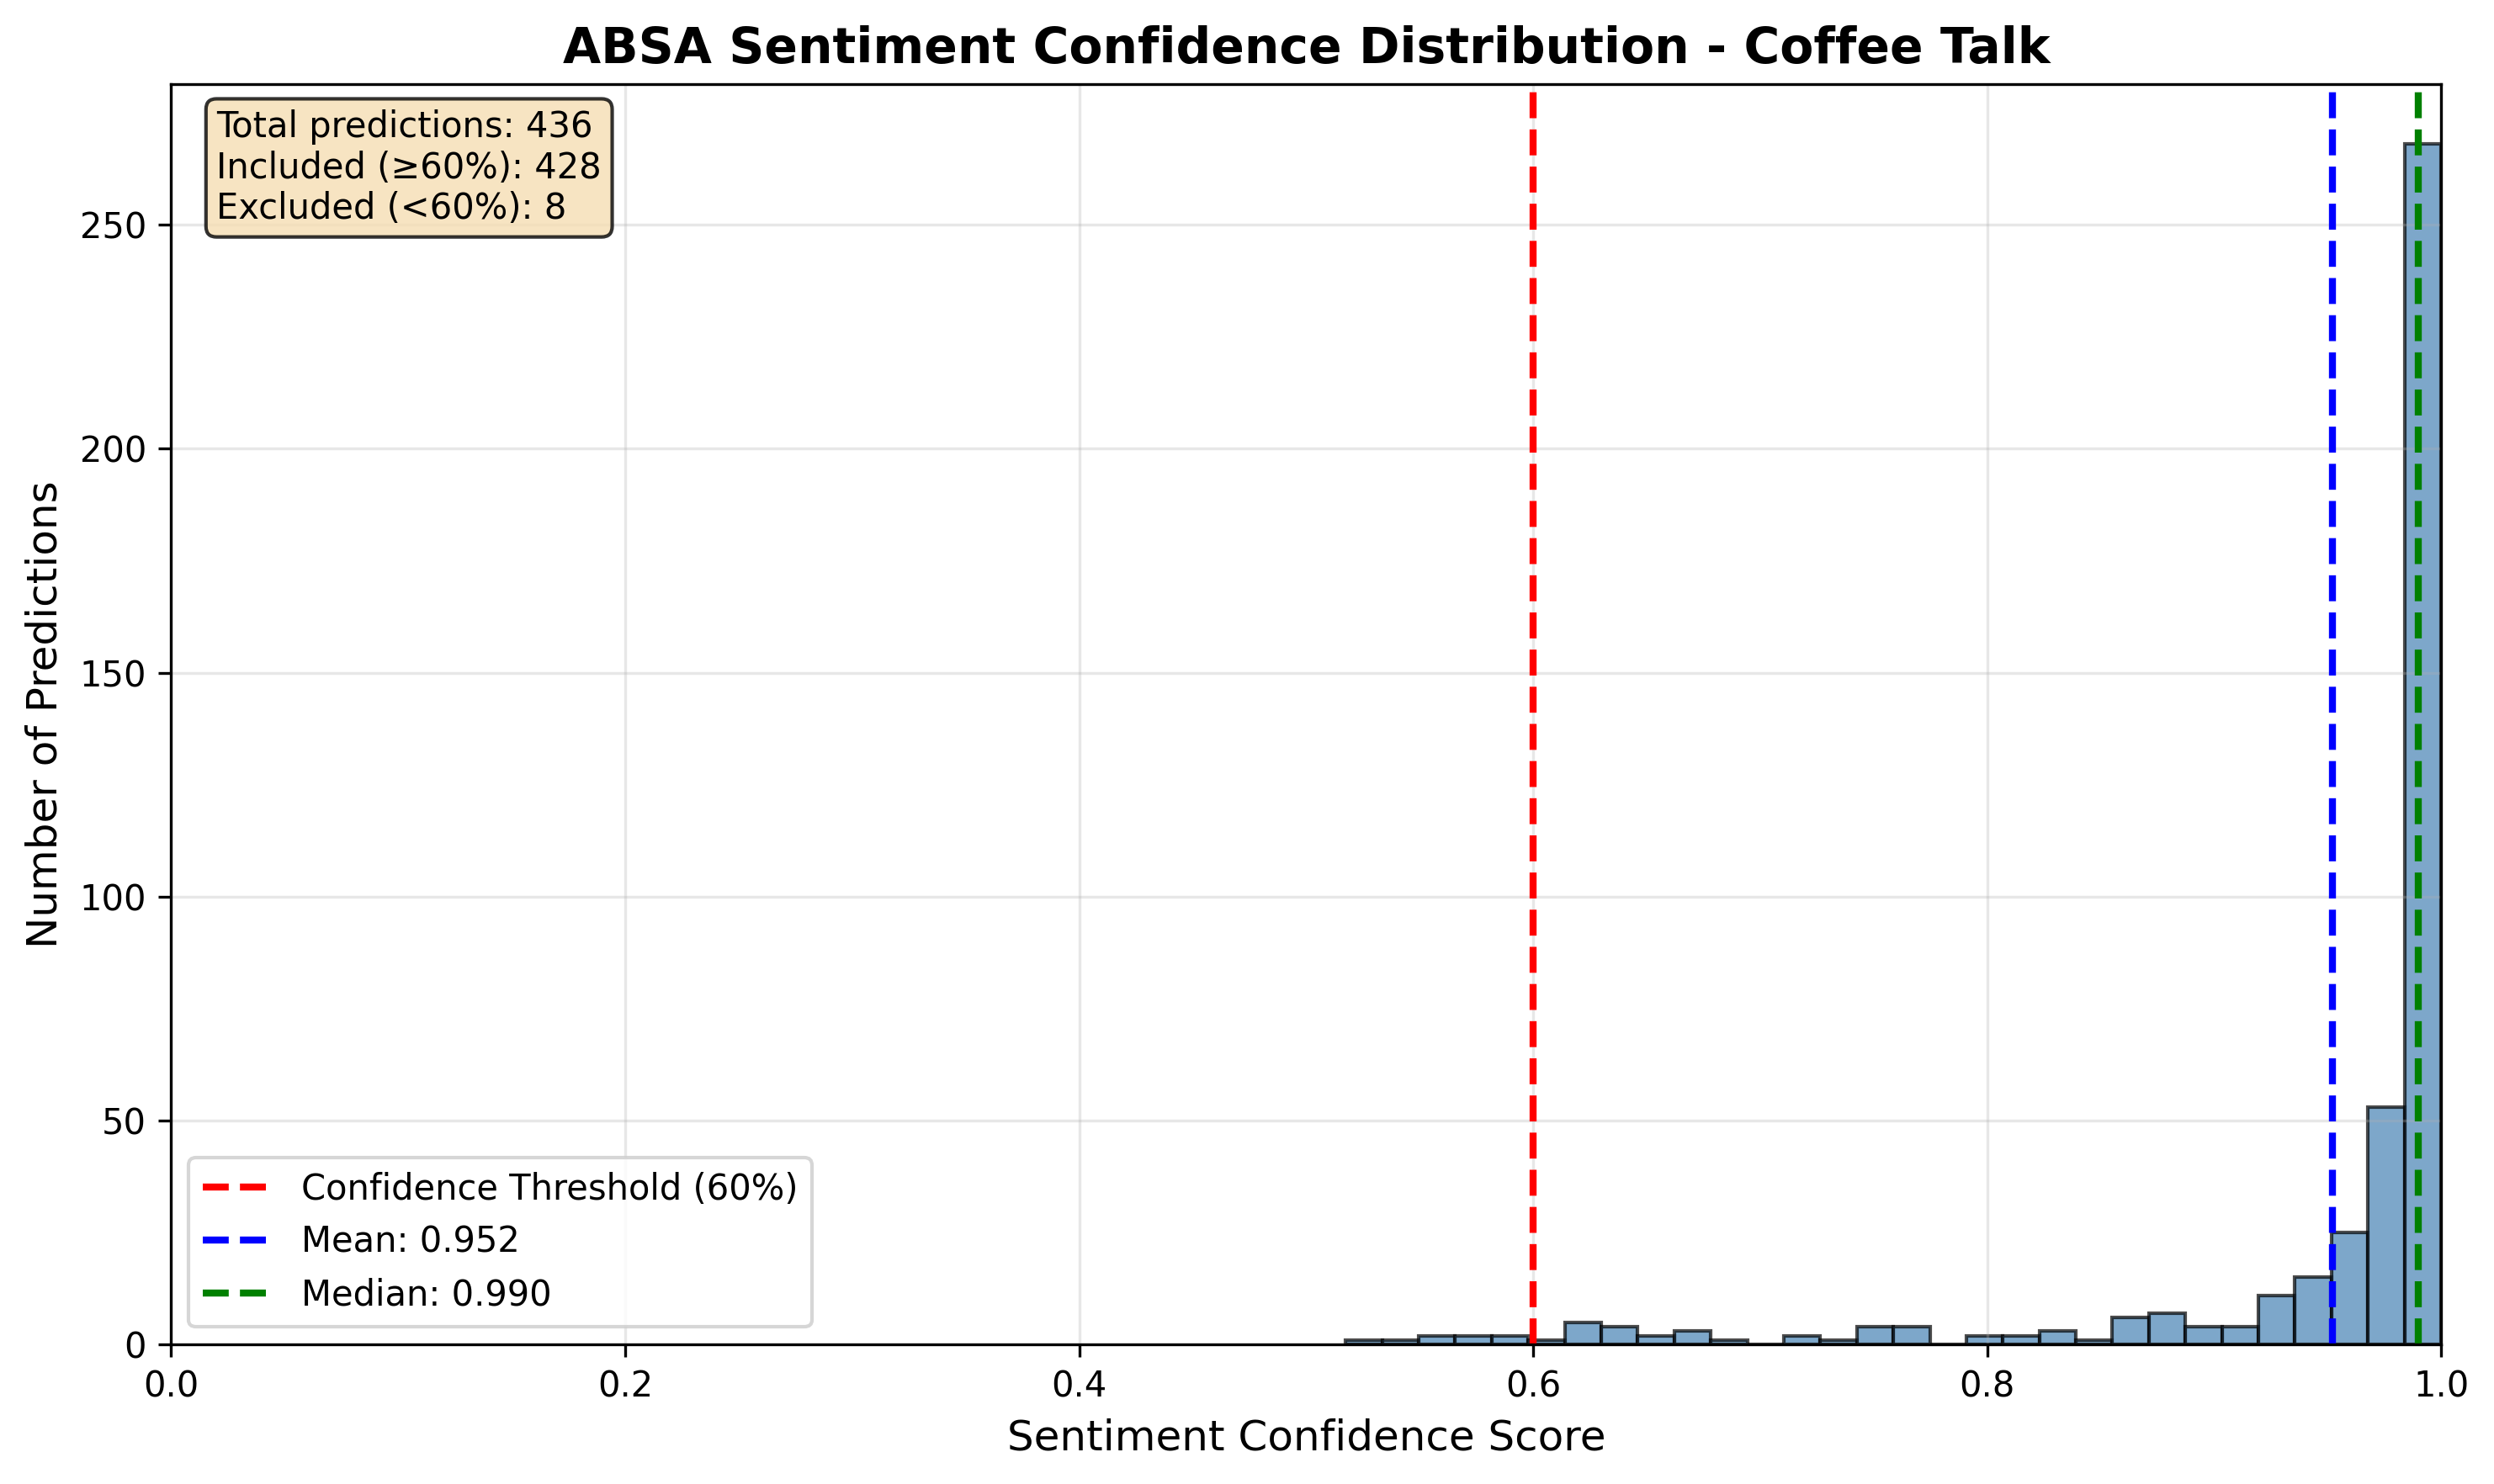


🔍 Discovered Topics (NMF):


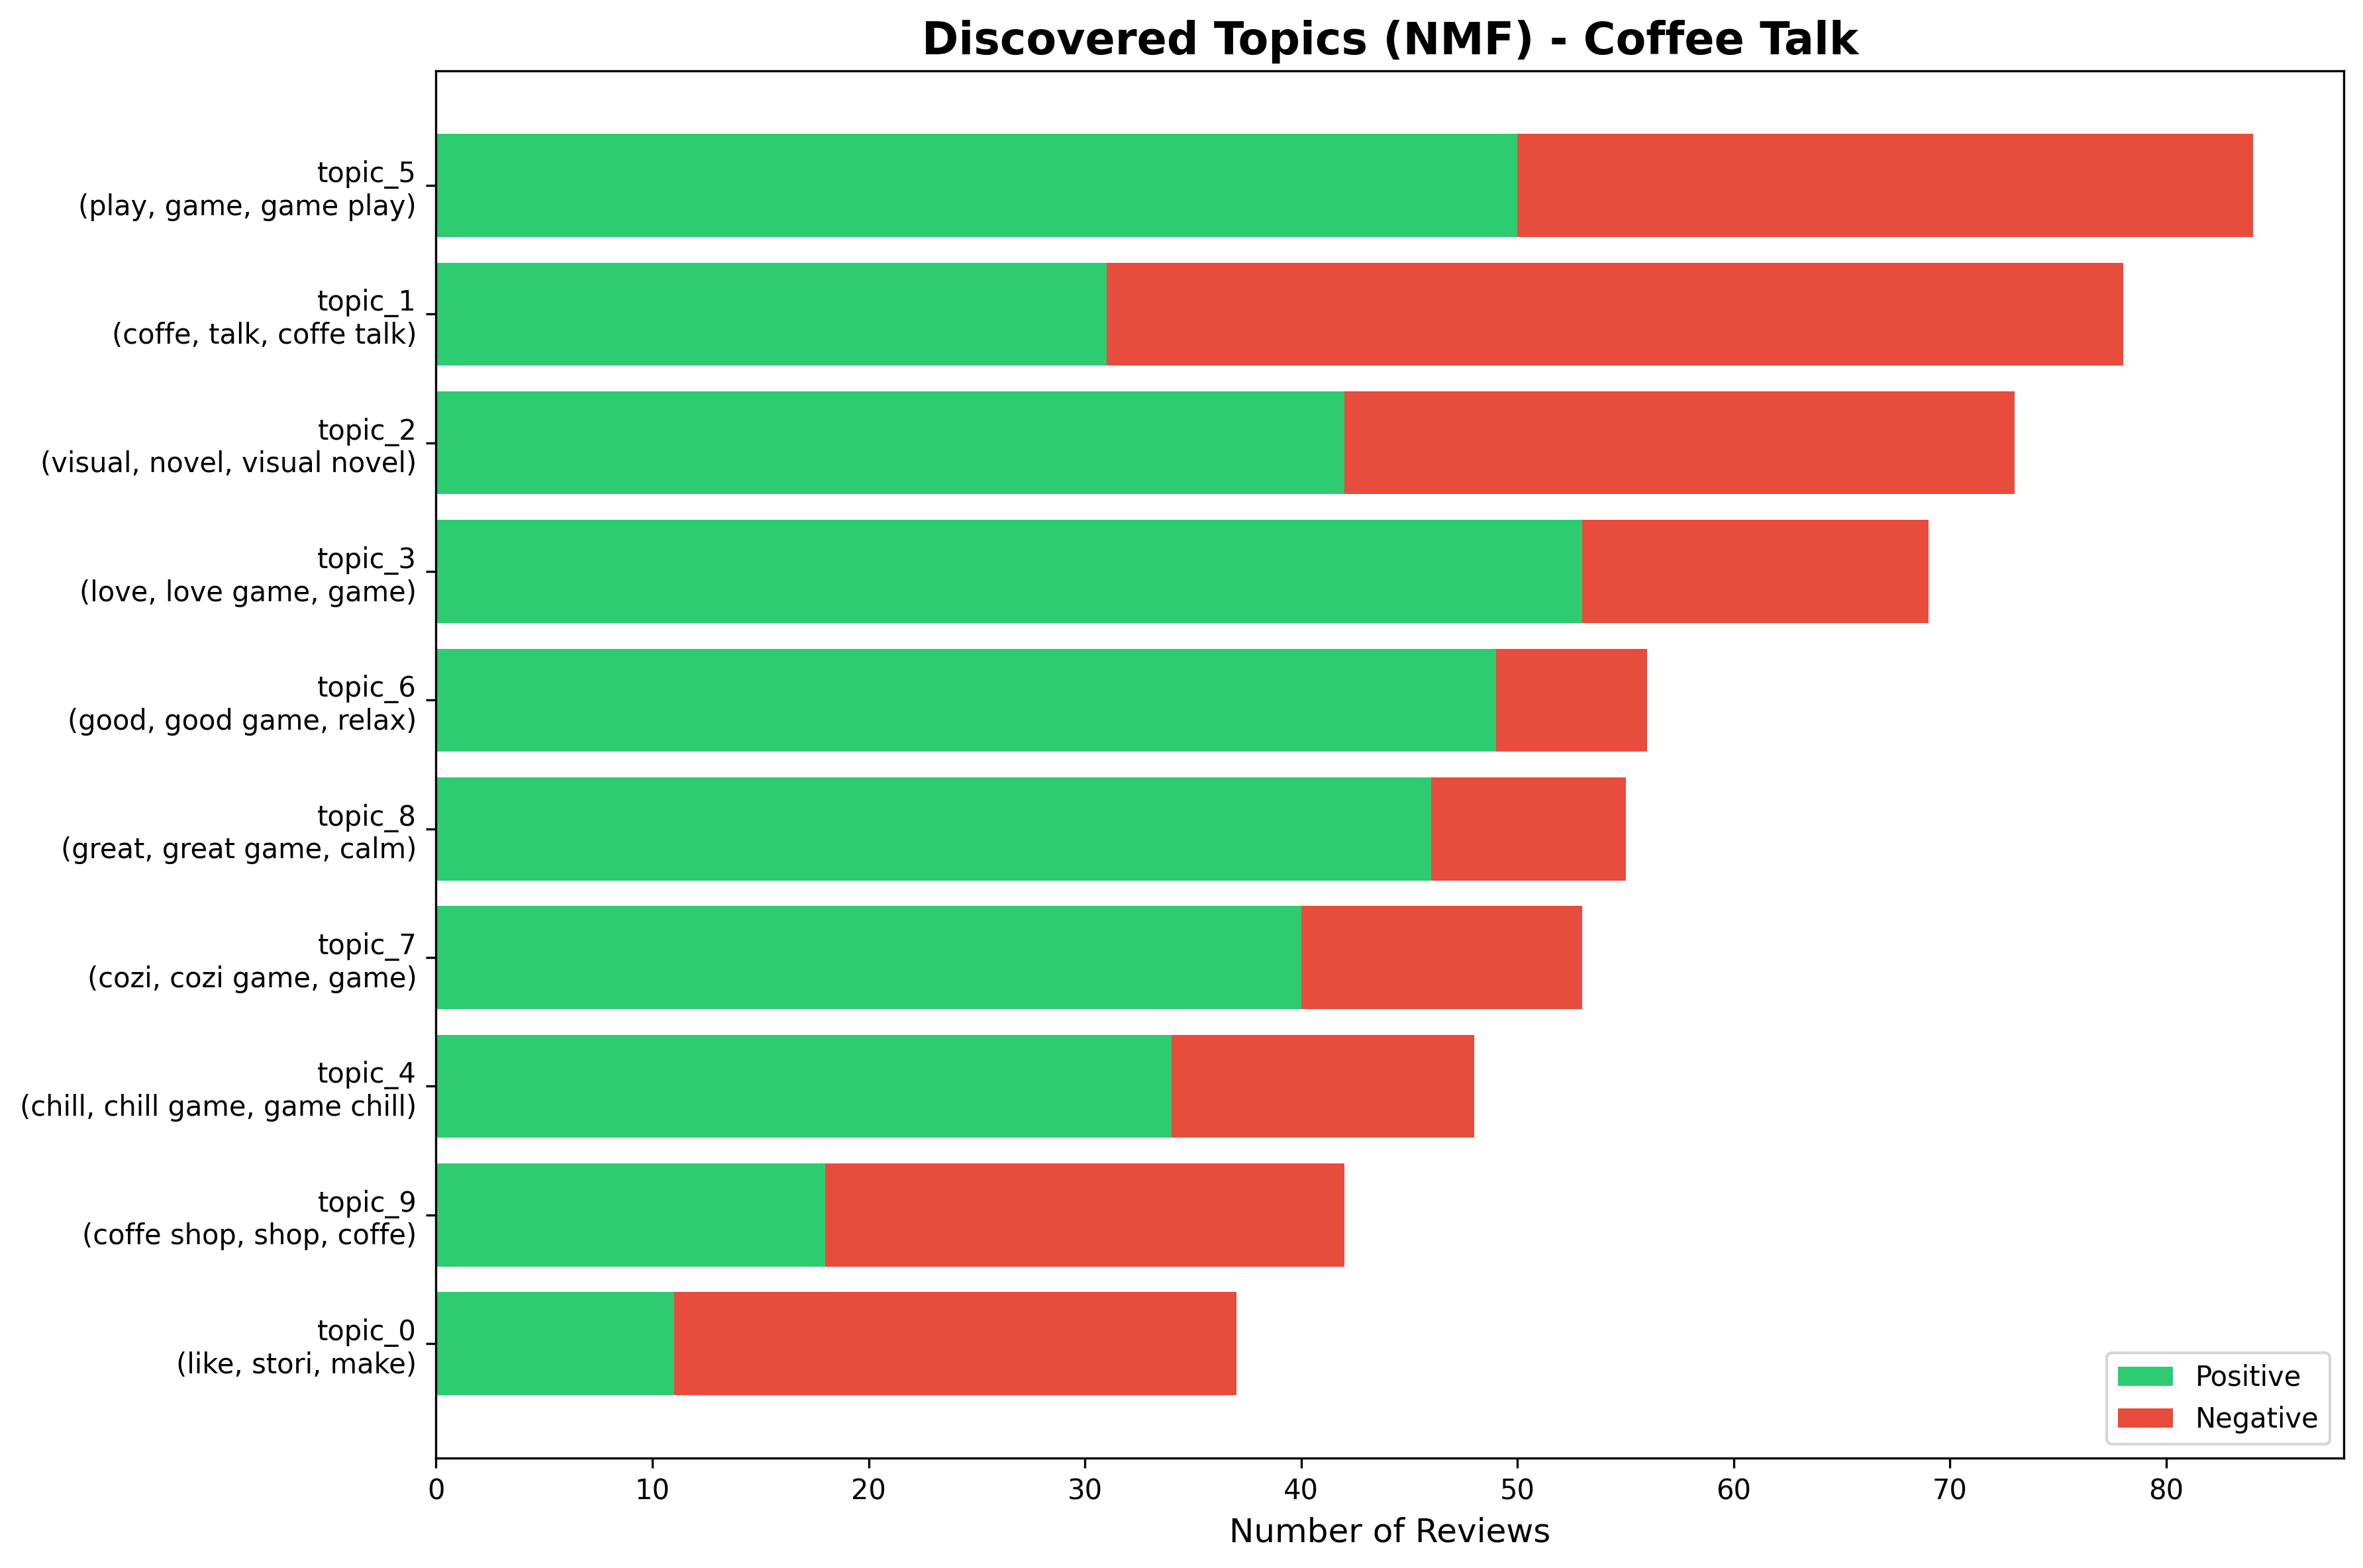

In [7]:
if 'credible_df' in locals():
    # First, install tf-keras if needed for sentiment model
    import subprocess
    import sys
    
    try:
        import tf_keras
    except ImportError:
        print("📦 Installing tf-keras for sentiment analysis compatibility...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tf-keras"])
    
    # Create game-specific directories
    game_id = game_info['id']
    game_outputs = Path(f"outputs/game_{game_id}")
    absa_viz_dir = game_outputs / "visualizations/absa"
    absa_viz_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize ABSA analyzer with game-specific path
    absa = ABSAAnalyzer(viz_dir=absa_viz_dir)
    
    print("📊 Running Aspect-Based Sentiment Analysis...")
    print("This includes both keyword-based and topic modeling approaches...")
    
    # Debug: Show sample reviews to check content
    print(f"\nDebug - Sample review texts:")
    for i, review in enumerate(credible_df['review'].head(3)):
        print(f"{i+1}. {review[:100]}...")
    
    # Run ABSA
    absa_results = absa.analyze(
        credible_df,
        game_name=game_info['name'],
        run_nmf=True,
        n_topics=10
    )
    
    # Display results
    summary = absa_results['summary']
    print(f"\n✅ ABSA Analysis Complete!")
    print(f"\nSummary:")
    print(f"- Keyword aspects found: {summary['total_keyword_aspects']}")
    print(f"- Topics discovered: {summary['total_discovered_topics']}")
    print(f"- Most mentioned: {summary['most_mentioned_aspect']}")
    print(f"- Most positive: {summary['most_positive_aspect']}")
    print(f"- Most negative: {summary['most_negative_aspect']}")
    
    # Show aspect details
    if summary['total_keyword_aspects'] > 0:
        print("\nAspect Sentiment Breakdown:")
        aspect_data = []
        for aspect, data in absa_results['keyword_aspects'].items():
            aspect_data.append({
                'Aspect': aspect,
                'Mentions': data['mentions'],
                'Positive %': f"{data['percent_positive']:.1f}%",
                'Confidence': f"{data['avg_confidence']:.3f}"
            })
        
        aspect_df = pd.DataFrame(aspect_data).sort_values('Mentions', ascending=False)
        display(aspect_df)
        
        # Display ALL ABSA visualizations using clean file names
        absa_viz_files = [
            ('aspect_sentiment_analysis.png', '📊 Aspect Sentiment Analysis'),
            ('overall_sentiment_distribution.png', '🥧 Overall Sentiment Distribution'),
            ('aspect_analysis_heatmap.png', '🔥 Aspect Analysis Heatmap'),
            ('absa_confidence_distribution.png', '📈 ABSA Confidence Distribution'),
            ('discovered_topics_nmf.png', '🔍 Discovered Topics (NMF)')
        ]
        
        for filename, title in absa_viz_files:
            viz_file = absa_viz_dir / filename
            if viz_file.exists():
                print(f"\n{title}:")
                display(Image(filename=str(viz_file)))
            else:
                print(f"\n⚠️ {title}: Not found")
    else:
        print("\n⚠️ No keyword aspects found. This might be due to:")
        print("- Review text not in expected format")
        print("- Keywords not matching review content")
        print("- Need to adjust aspect keywords for this game type")
        
        # Show what keywords we're looking for
        print("\nSearching for these aspect keywords:")
        for aspect, keywords in absa.aspect_keywords.items():
            print(f"- {aspect}: {', '.join(keywords[:5])}...")

## Step 7: Emotion Analysis

Classify emotions using an ensemble of GPT-2, RoBERTa, and DeBERTa models.

**Note**: This requires pre-trained models in the checkpoints directory. For large datasets, consider using sampling.

🔍 Checking for emotion models...
✅ gpt2: Found
✅ roberta: Found
✅ deberta: Found

🎭 Running emotion analysis on 914 reviews...
This may take several minutes...
Loading trained models...
GPT-2 Model loaded: gpt2-medium
Total parameters: 361,121,792
Trainable parameters: 58,910,720
Percentage trainable: 16.31%
gpt2 loaded from c:\Users\steve\OneDrive\Desktop\MathM148v3\MathM148_FinalPipeline\models\gpt2\final_model.pt
Initializing RoBERTa tokenizer: roberta-base
Building RoBERTa model with LoRA (rank=16, alpha=16)
Applied LoRA to 72 layers
RoBERTa Model loaded: roberta-base
Total parameters: 127,304,454
Trainable parameters: 42,286,854
Percentage trainable: 33.22%
roberta loaded from c:\Users\steve\OneDrive\Desktop\MathM148v3\MathM148_FinalPipeline\models\roberta\final_model.pt
Initializing DeBERTa-v3 tokenizer: microsoft/deberta-v3-base
Building DeBERTa-v3 model with LoRA (rank=16, alpha=16)
Disentangled attention: True
Applied LoRA to 72 layers
DeBERTa-v3 Model loaded: microsoft/debert

Predicting emotions (3 models): 100%|██████████| 39/39 [00:19<00:00,  2.02batch/s]



✅ Emotion Analysis Complete!

Results:
- Total analyzed: 914
- Overall confidence: 0.654
- High confidence ratio: 27.7%

Emotion Distribution:


,Emotion,Percentage,Count,Avg Confidence
0,joy,71.4%,653,0.712
1,anger,22.8%,208,0.482
2,sadness,4.2%,38,0.648
3,fear,0.8%,7,0.447
4,love,0.8%,7,0.578
5,surprise,0.1%,1,0.737



🎭 Emotion Distribution (Pie & Bar Charts):


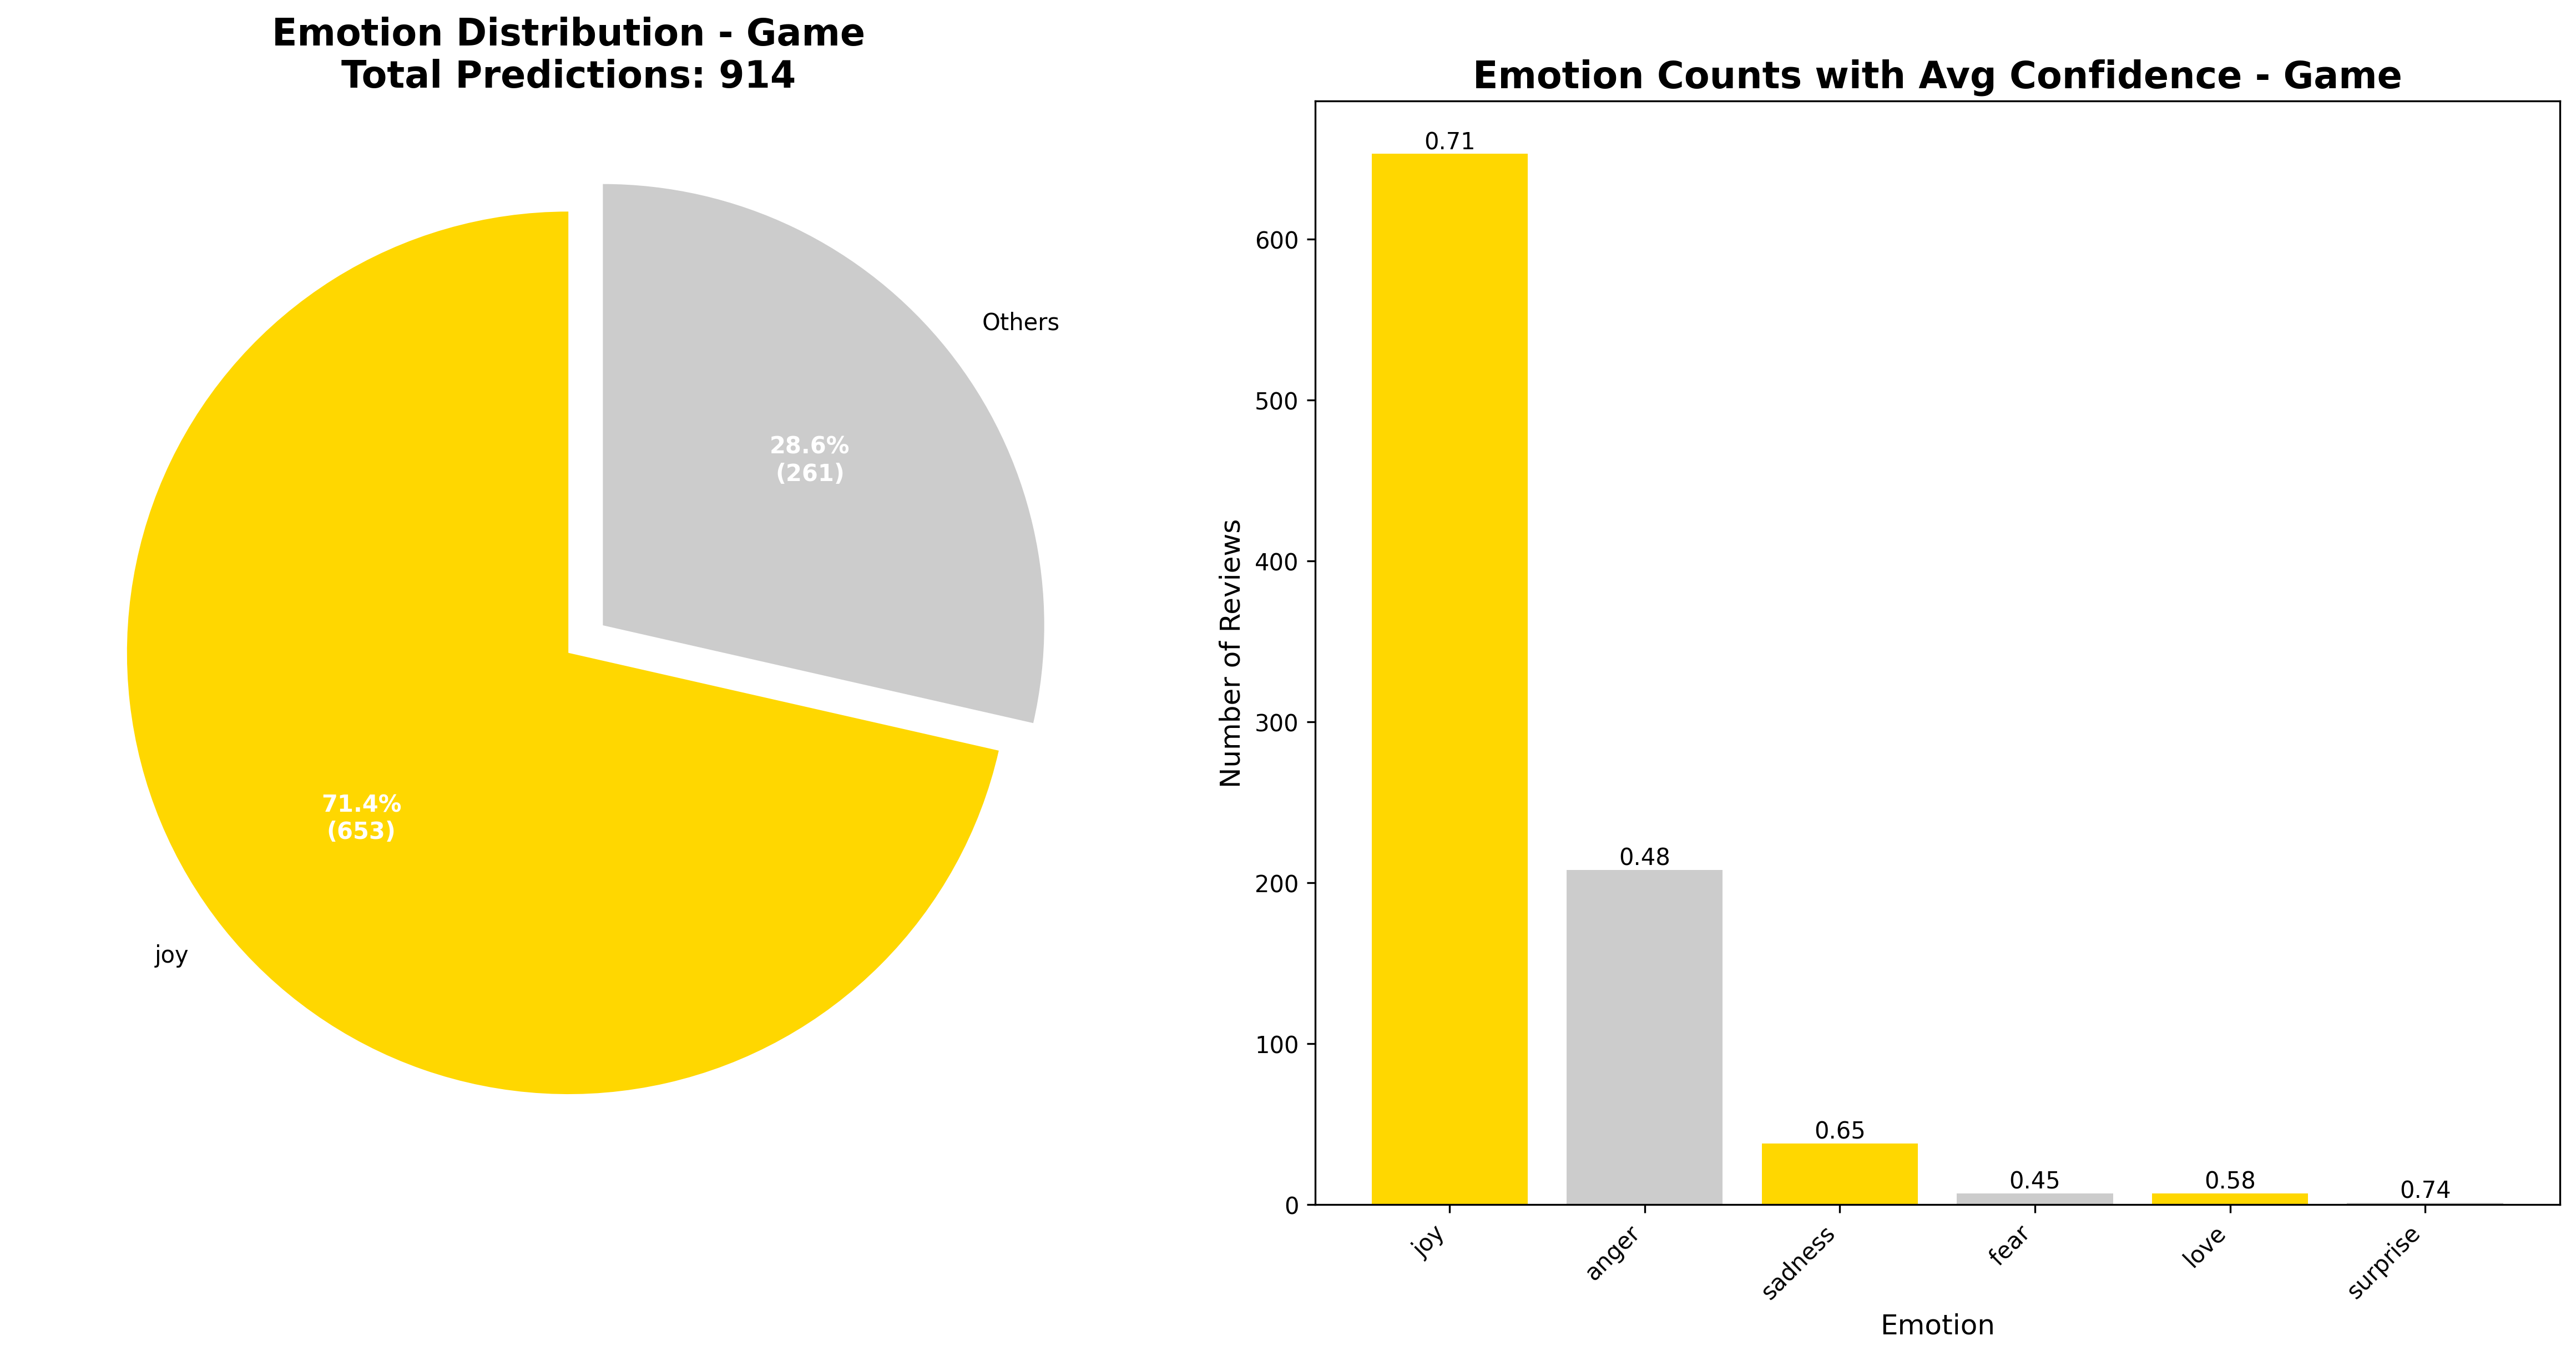


📊 Confidence Score Distribution:


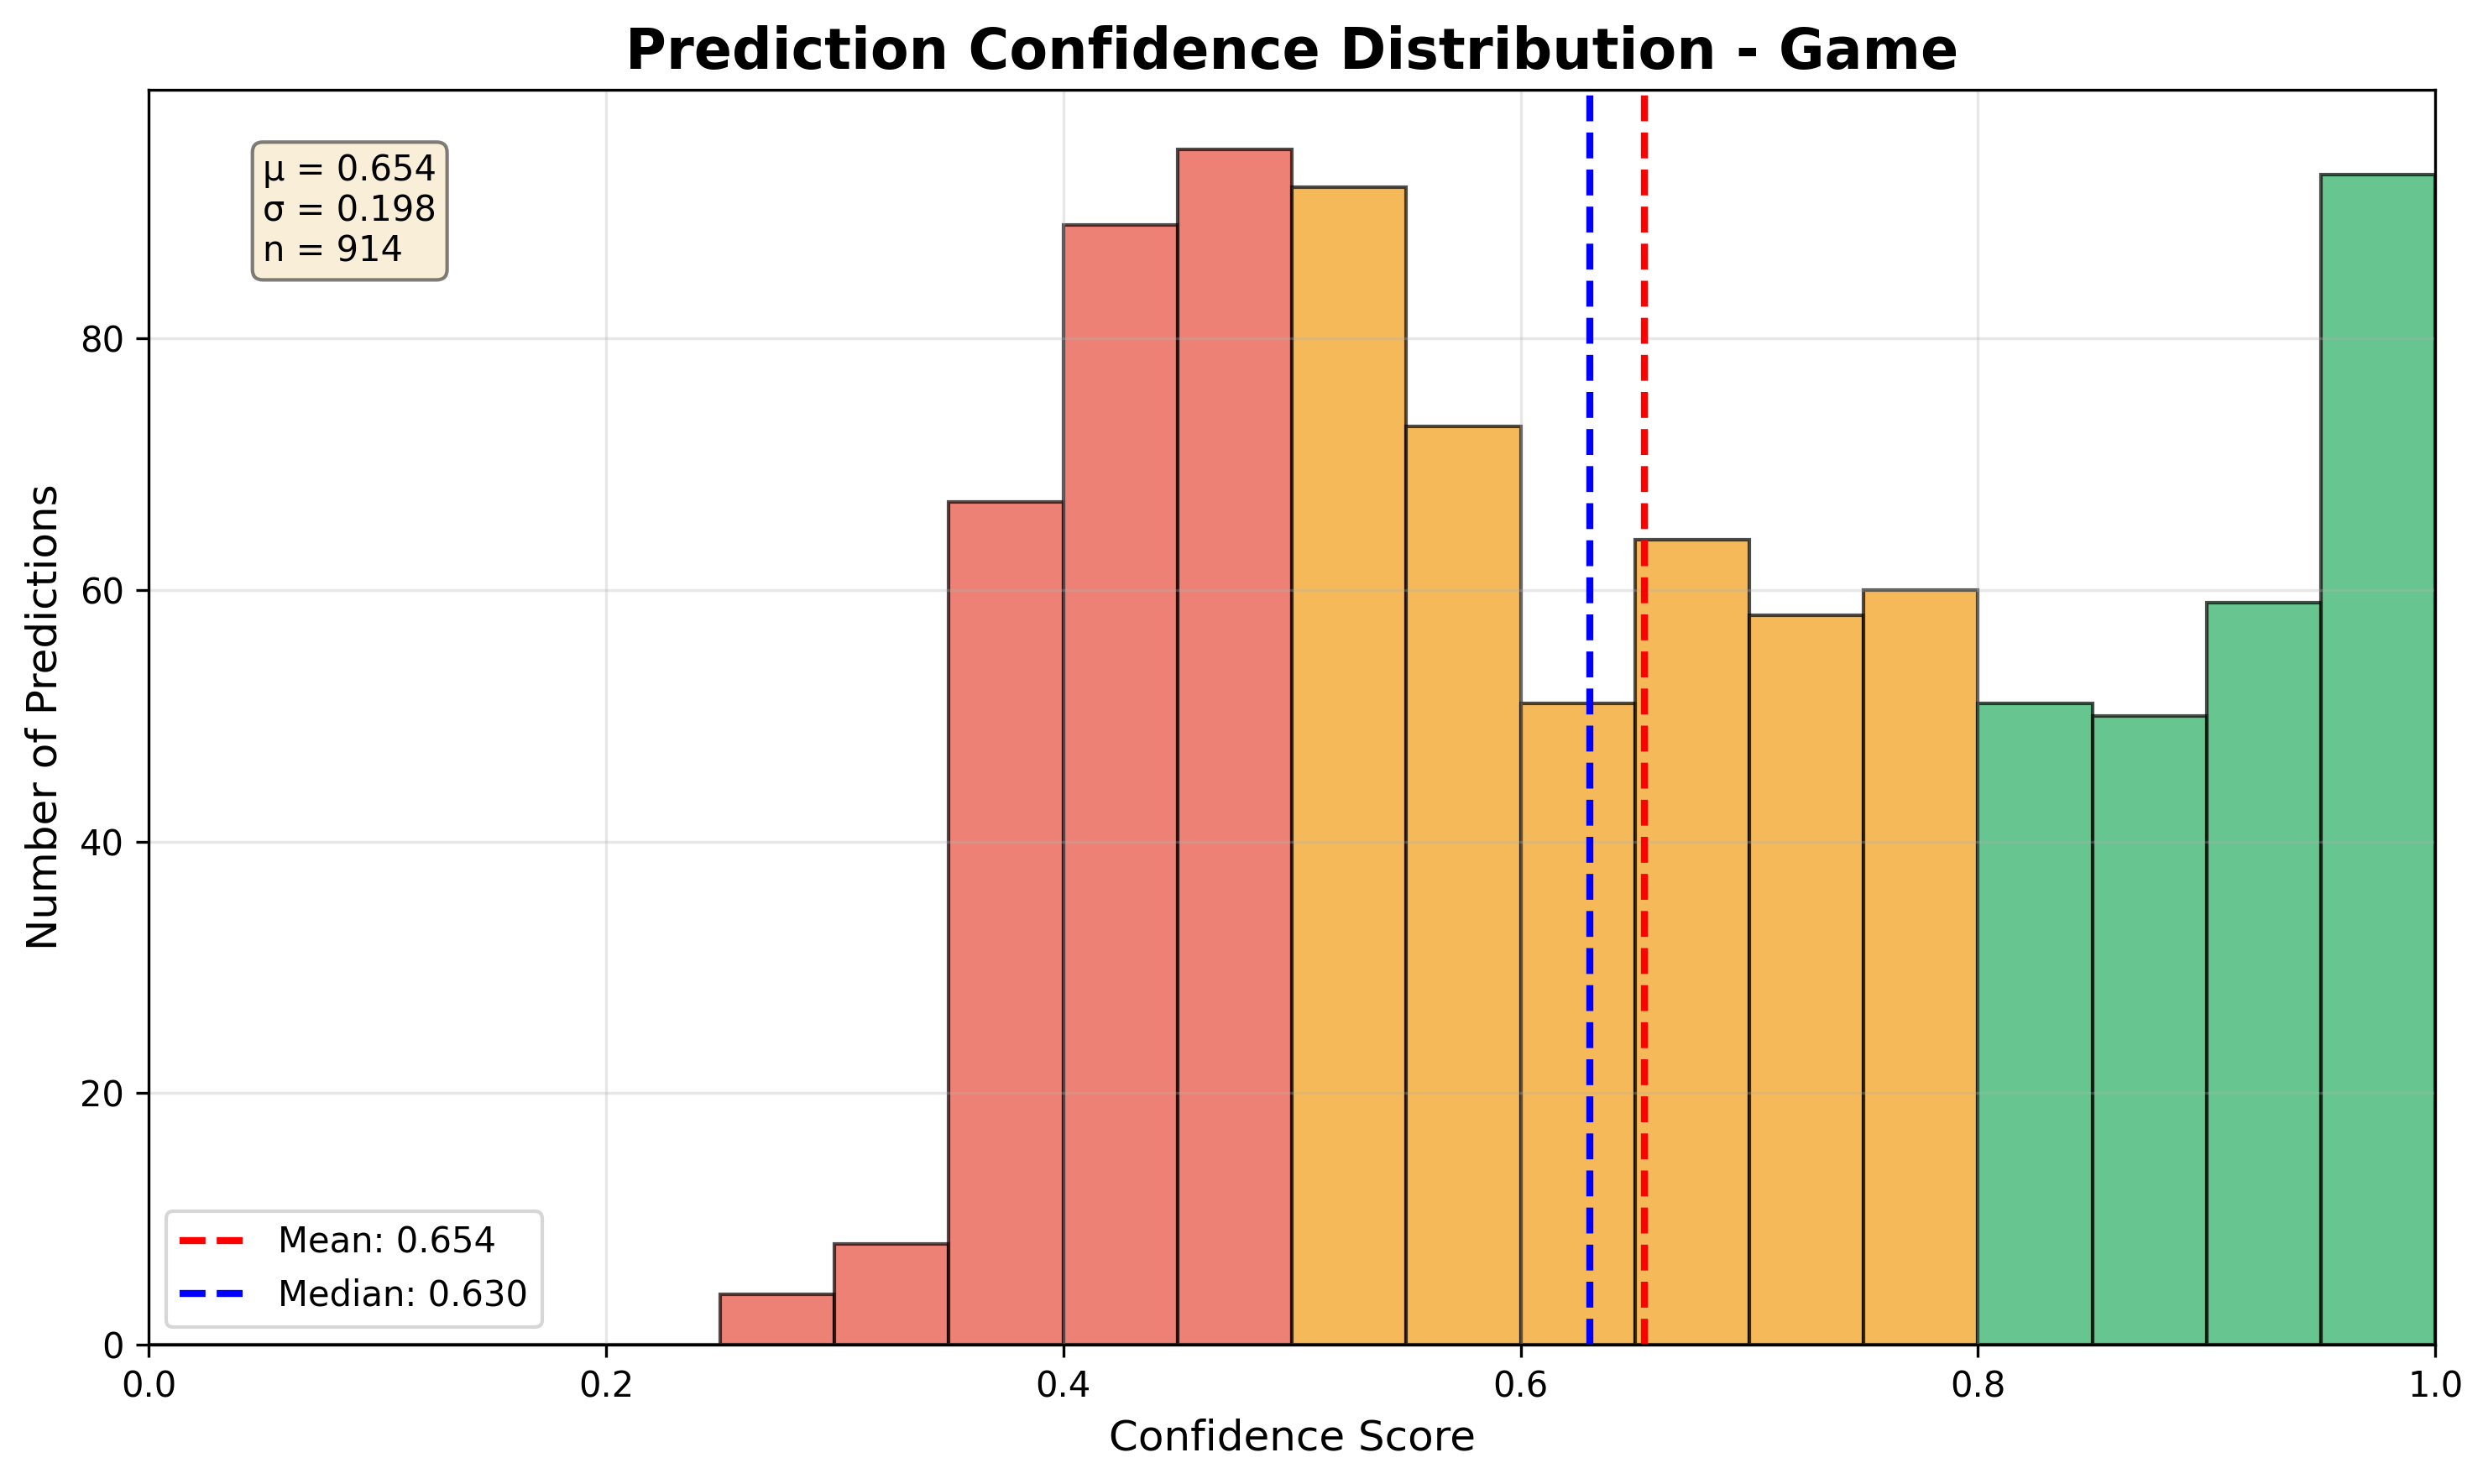


🤝 Model Agreement Analysis:


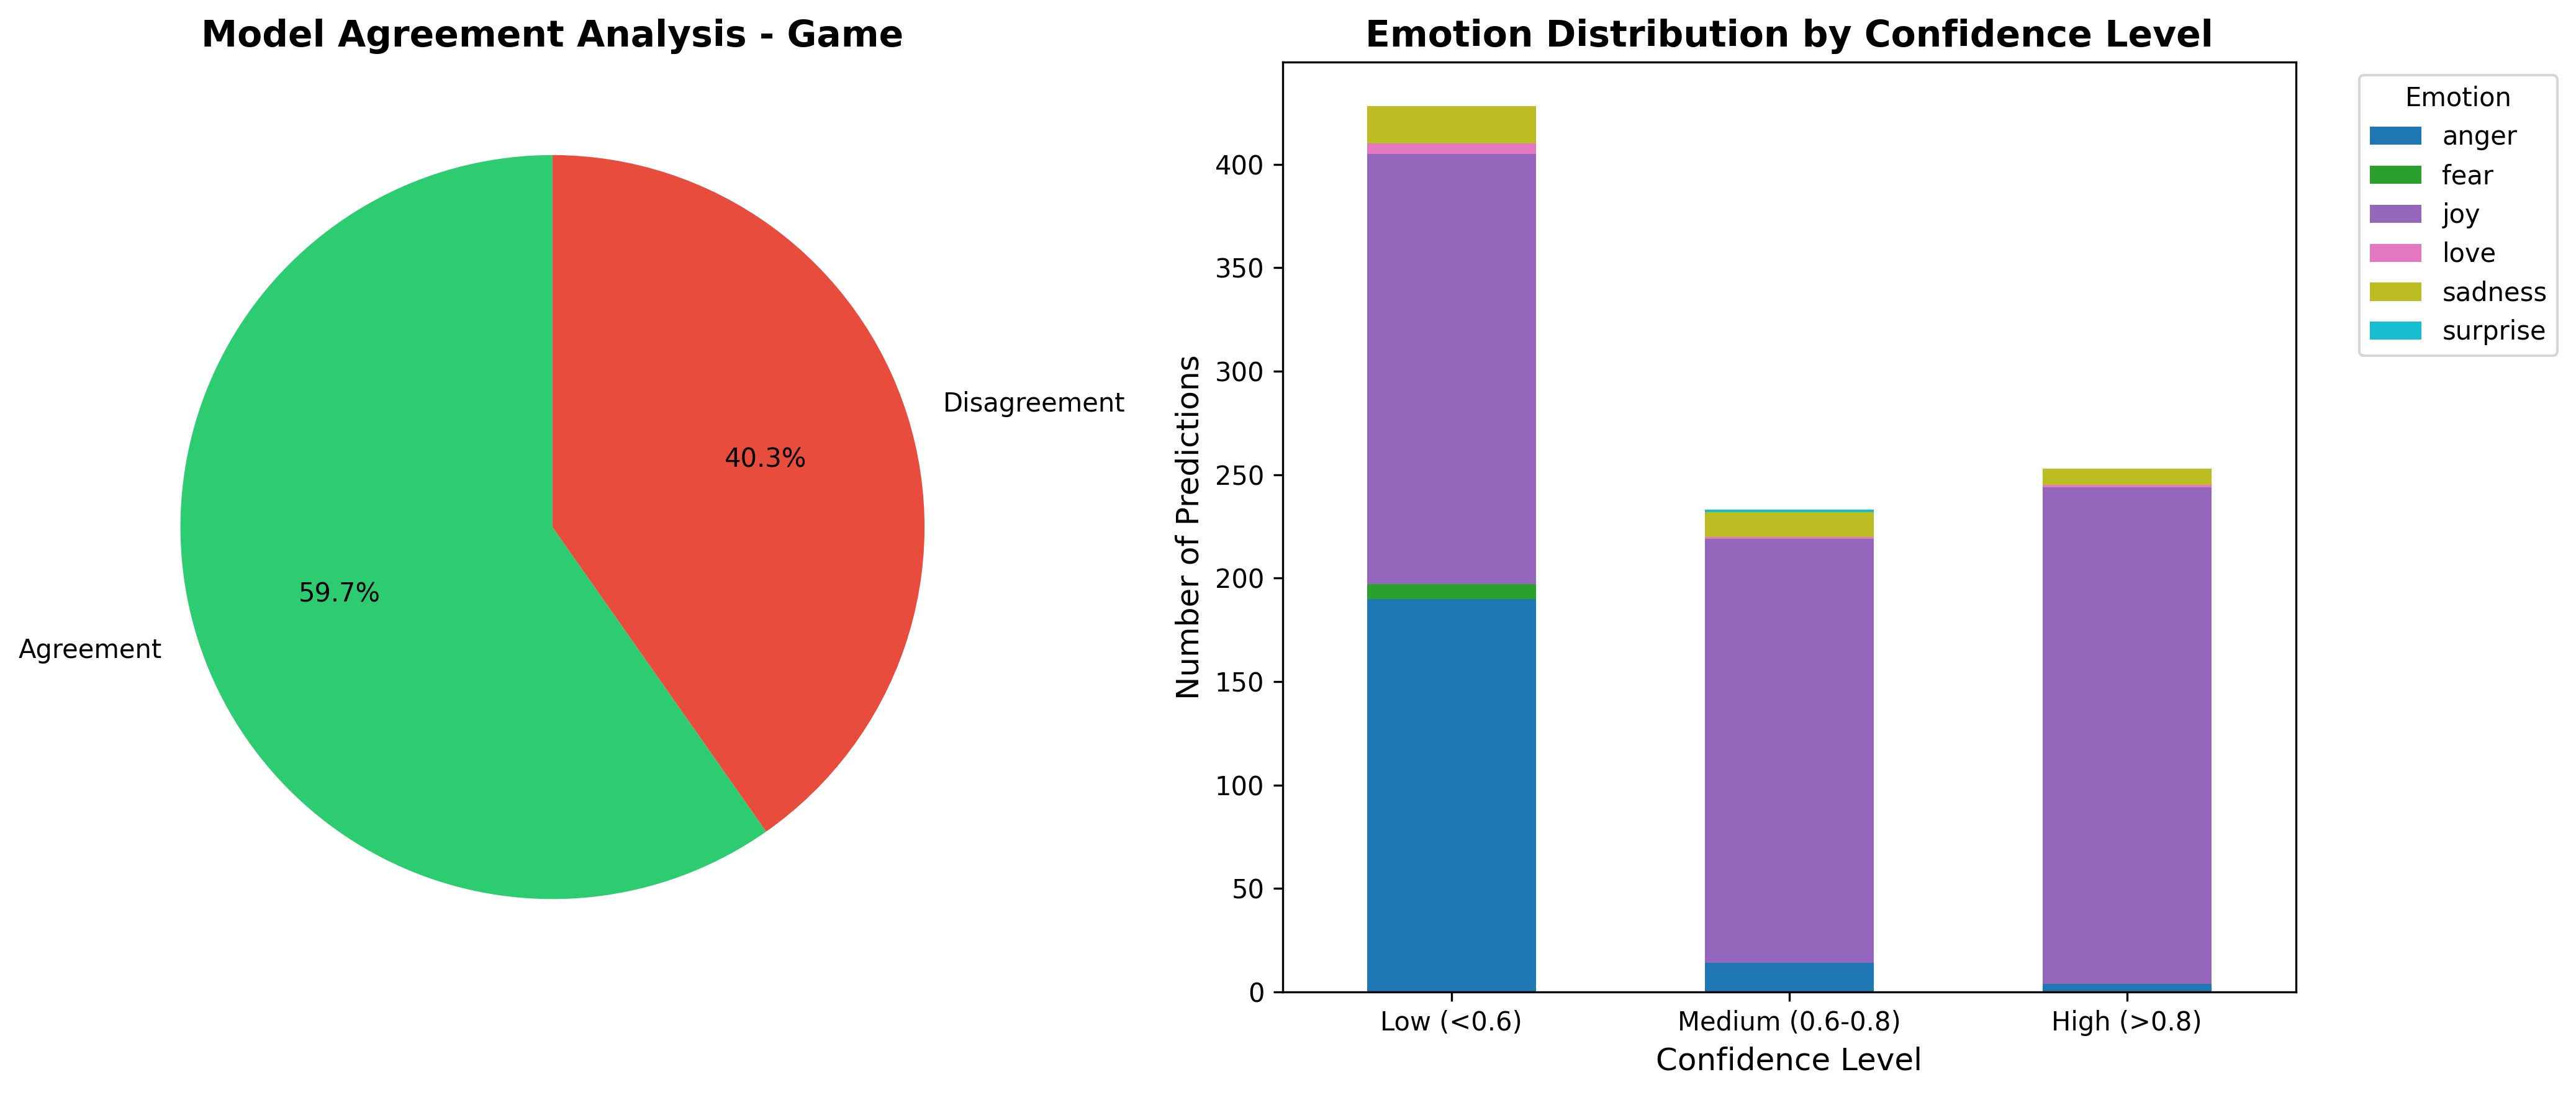


🧮 Model Disagreement Analysis (Jensen-Shannon Divergence):


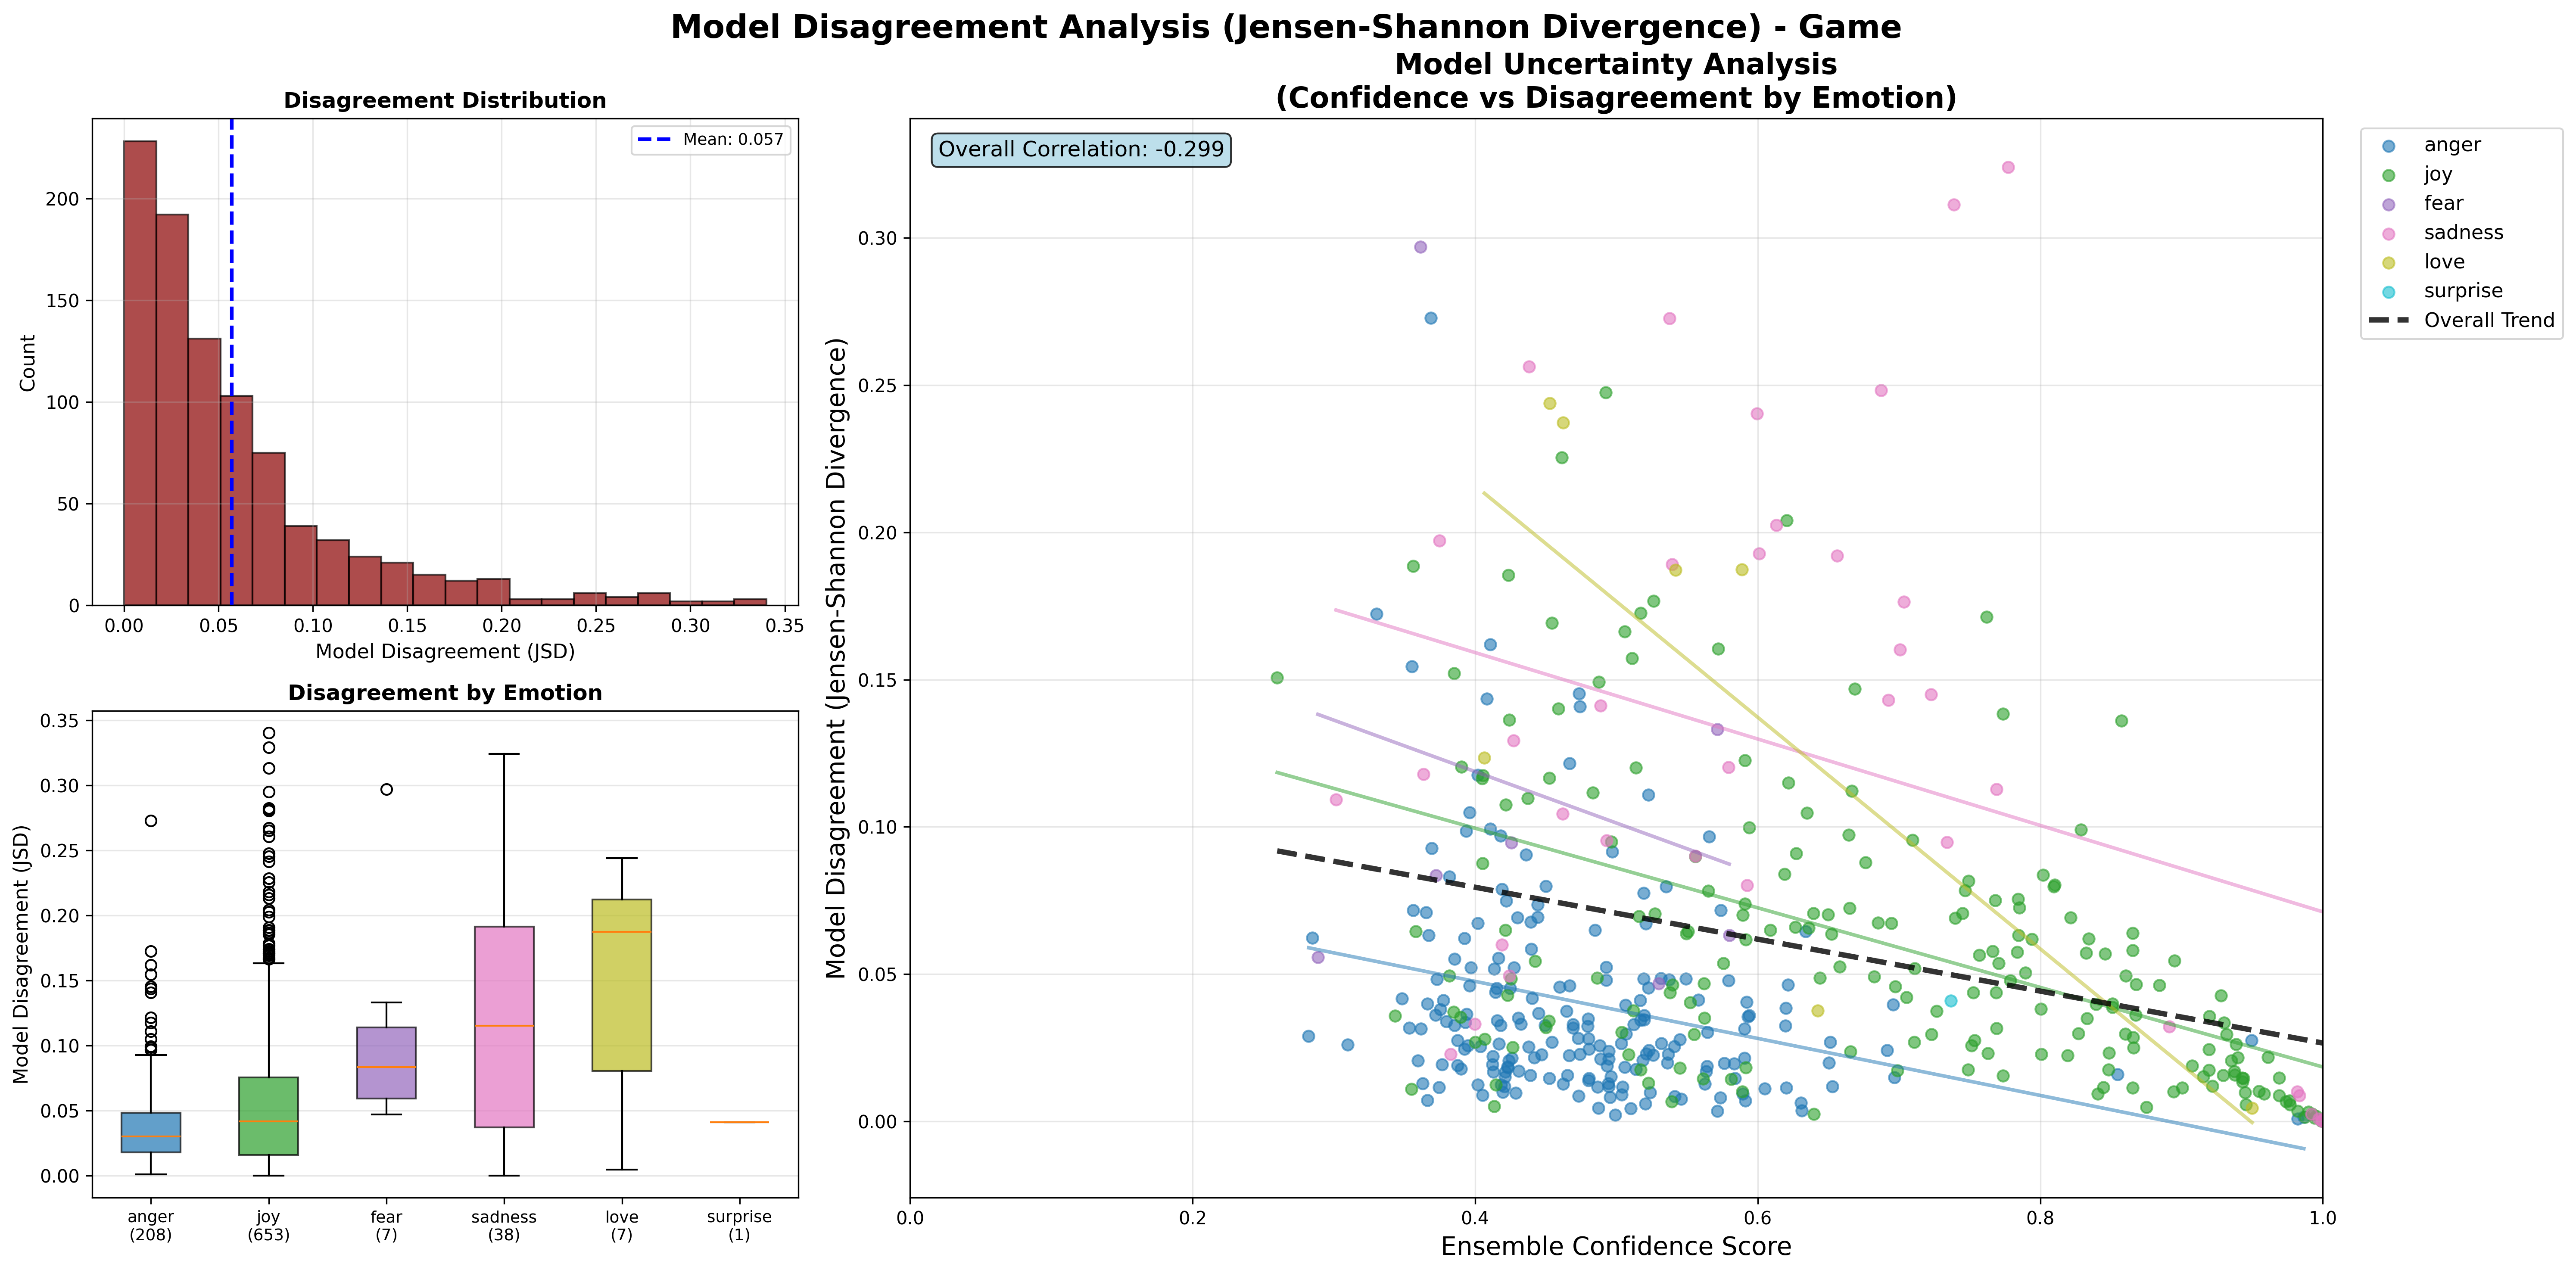


Model Agreement Analysis:
- Sample size: 914
- Disagreement rate: 40.3%


In [8]:
if 'credible_df' in locals():
    # Create game-specific directories
    game_id = game_info['id']
    game_outputs = Path(f"outputs/game_{game_id}")
    emotions_viz_dir = game_outputs / "visualizations/emotions"
    emotions_viz_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize emotion analyzer with game-specific path and updated checkpoint path
    emotion_analyzer = EmotionAnalyzer(
        viz_dir=emotions_viz_dir,
        checkpoint_dir=Path("models")  # Updated to use new models location
    )
    
    # Check if models exist
    print("🔍 Checking for emotion models...")
    model_status = emotion_analyzer.check_models_exist()
    
    for model, exists in model_status.items():
        status = "✅" if exists else "❌"
        print(f"{status} {model}: {'Found' if exists else 'Not found'}")
    
    if all(model_status.values()):
        # Determine sample size
        EMOTION_SAMPLE_SIZE = min(5000, len(credible_df))  # Adjust as needed
        
        print(f"\n🎭 Running emotion analysis on {EMOTION_SAMPLE_SIZE} reviews...")
        print("This may take several minutes...")
        
        # Run analysis
        emotion_results = emotion_analyzer.analyze_reviews(
            credible_df,
            text_column='review',
            sample_size=EMOTION_SAMPLE_SIZE
        )
        
        if emotion_results:
            print(f"\n✅ Emotion Analysis Complete!")
            print(f"\nResults:")
            print(f"- Total analyzed: {emotion_results['total_analyzed']}")
            print(f"- Overall confidence: {emotion_results['overall_avg_confidence']:.3f}")
            print(f"- High confidence ratio: {emotion_results['high_confidence_ratio']:.1%}")
            
            # Show emotion distribution
            print("\nEmotion Distribution:")
            emotion_df = pd.DataFrame([
                {
                    'Emotion': emotion,
                    'Percentage': f"{pct:.1f}%",
                    'Count': emotion_results['emotion_counts'][emotion],
                    'Avg Confidence': f"{emotion_results['avg_confidence_by_emotion'][emotion]:.3f}"
                }
                for emotion, pct in sorted(emotion_results['emotion_percentages'].items(), 
                                         key=lambda x: x[1], reverse=True)
            ])
            display(emotion_df)
            
            # Display ALL emotion visualizations using clean file names
            emotion_viz_files = [
                ('emotion_distribution.png', '🎭 Emotion Distribution (Pie & Bar Charts)'),
                ('confidence_distribution.png', '📊 Confidence Score Distribution'),
                ('model_agreement_analysis.png', '🤝 Model Agreement Analysis'),
                ('model_disagreement_analysis.png', '🧮 Model Disagreement Analysis (Jensen-Shannon Divergence)')
            ]
            
            for filename, title in emotion_viz_files:
                viz_file = emotions_viz_dir / filename
                if viz_file.exists():
                    print(f"\n{title}:")
                    display(Image(filename=str(viz_file)))
                else:
                    print(f"\n⚠️ {title}: Not found")
            
            # Show disagreement stats
            disagree = emotion_results.get('disagreement_stats', {})
            if disagree:
                print(f"\nModel Agreement Analysis:")
                print(f"- Sample size: {disagree.get('sample_size', 0)}")
                print(f"- Disagreement rate: {disagree.get('disagreement_rate', 0):.1%}")
        else:
            print("\n❌ No emotion results generated")
    else:
        print("\n❌ Cannot run emotion analysis without models.")
        print("Please ensure models are downloaded to the models/ directory.")

## Final Summary

Compile and display all insights from the analysis.

In [9]:
print("="*80)
print(f"COMPLETE ANALYSIS SUMMARY - {game_info['name']}")
print("="*80)

# Data overview
print("\n📊 DATA OVERVIEW:")
print(f"- Total reviews scraped: {len(reviews_df) if 'reviews_df' in locals() else 'N/A'}")
print(f"- Credible reviews: {len(credible_df) if 'credible_df' in locals() else 'N/A'}")
print(f"- Fake reviews filtered: {len(fake_df) if 'fake_df' in locals() else 'N/A'}")

# ABSA insights
if 'absa_results' in locals():
    print("\n🔍 ASPECT INSIGHTS:")
    summary = absa_results['summary']
    print(f"- Most discussed: {summary['most_mentioned_aspect']}")
    print(f"- Most positive: {summary['most_positive_aspect']}")
    print(f"- Most negative: {summary['most_negative_aspect']}")
    
    # Top 3 aspects by mention
    top_aspects = sorted(absa_results['keyword_aspects'].items(), 
                        key=lambda x: x[1]['mentions'], reverse=True)[:3]
    print("\nTop aspects by mentions:")
    for aspect, data in top_aspects:
        print(f"  - {aspect}: {data['mentions']} mentions ({data['percent_positive']:.0f}% positive)")

# Emotion insights
if 'emotion_results' in locals():
    print("\n🎭 EMOTION INSIGHTS:")
    
    # Dominant emotion
    dominant = max(emotion_results['emotion_percentages'].items(), key=lambda x: x[1])
    print(f"- Dominant emotion: {dominant[0]} ({dominant[1]:.1f}%)")
    
    # Emotional valence
    positive_emotions = ['joy', 'love', 'surprise']
    negative_emotions = ['sadness', 'anger', 'fear']
    
    positive_pct = sum(emotion_results['emotion_percentages'].get(e, 0) for e in positive_emotions)
    negative_pct = sum(emotion_results['emotion_percentages'].get(e, 0) for e in negative_emotions)
    
    print(f"\nEmotional Valence:")
    print(f"  - Positive emotions: {positive_pct:.1f}%")
    print(f"  - Negative emotions: {negative_pct:.1f}%")
    if negative_pct > 0:
        print(f"  - Positive/Negative ratio: {positive_pct/negative_pct:.2f}:1")

# File locations with new structure
game_id = game_info['id']
print("\n📁 OUTPUT FILES:")
print(f"- Game outputs: outputs/game_{game_id}/")
print(f"- Visualizations: outputs/game_{game_id}/visualizations/")
print(f"- Data files: outputs/game_{game_id}/data/")
print(f"- Logs: logs/")

print("\n✅ Analysis complete!")

COMPLETE ANALYSIS SUMMARY - Coffee Talk

📊 DATA OVERVIEW:
- Total reviews scraped: 1000
- Credible reviews: 914
- Fake reviews filtered: 86

🔍 ASPECT INSIGHTS:
- Most discussed: audio
- Most positive: audio
- Most negative: performance

Top aspects by mentions:
  - audio: 197 mentions (62% positive)
  - gameplay: 184 mentions (57% positive)
  - graphics: 175 mentions (52% positive)

🎭 EMOTION INSIGHTS:
- Dominant emotion: joy (71.4%)

Emotional Valence:
  - Positive emotions: 72.3%
  - Negative emotions: 27.7%
  - Positive/Negative ratio: 2.61:1

📁 OUTPUT FILES:
- Game outputs: outputs/game_914800/
- Visualizations: outputs/game_914800/visualizations/
- Data files: outputs/game_914800/data/
- Logs: logs/

✅ Analysis complete!


## Export Results

Save the complete analysis results for future reference.

In [10]:
# Compile all results
game_id = game_info['id']

# Create game-specific output directories
game_outputs = Path(f"outputs/game_{game_id}")
data_dir = game_outputs / "data"
data_dir.mkdir(parents=True, exist_ok=True)

complete_results = {
    'game_info': game_info,
    'analysis_timestamp': datetime.now().isoformat(),
    'config': ANALYSIS_CONFIG,
    'data_summary': {
        'total_reviews': len(reviews_df) if 'reviews_df' in locals() else 0,
        'credible_reviews': len(credible_df) if 'credible_df' in locals() else 0,
        'fake_reviews': len(fake_df) if 'fake_df' in locals() else 0
    }
}

# Add ABSA results
if 'absa_results' in locals():
    complete_results['absa_summary'] = absa_results['summary']
    complete_results['aspect_sentiments'] = {
        aspect: {
            'mentions': data['mentions'],
            'positive_percentage': data['percent_positive']
        }
        for aspect, data in absa_results['keyword_aspects'].items()
    }

# Add emotion results
if 'emotion_results' in locals():
    complete_results['emotion_summary'] = {
        'total_analyzed': emotion_results['total_analyzed'],
        'overall_confidence': emotion_results['overall_avg_confidence'],
        'emotion_distribution': emotion_results['emotion_percentages']
    }

# Save results to game-specific directory with clean name
results_file = data_dir / "analysis_results.json"

# Handle backup if overwrite mode
if ANALYSIS_CONFIG['overwrite_previous'] and results_file.exists() and ANALYSIS_CONFIG['keep_backup']:
    backup_file = data_dir / f"analysis_results_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    results_file.rename(backup_file)
    print(f"📋 Previous analysis backed up to {backup_file.name}")

with open(results_file, 'w') as f:
    json.dump(complete_results, f, indent=2)

print(f"✅ Results saved to: {results_file}")

# Also save credible reviews for future use
if 'credible_df' in locals():
    cleaned_dir = data_dir / "cleaned"
    cleaned_dir.mkdir(parents=True, exist_ok=True)
    credible_file = cleaned_dir / "credible_reviews.csv"
    
    # Handle backup if overwrite mode
    if ANALYSIS_CONFIG['overwrite_previous'] and credible_file.exists() and ANALYSIS_CONFIG['keep_backup']:
        backup_file = cleaned_dir / f"credible_reviews_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        credible_file.rename(backup_file)
        print(f"📋 Previous credible data backed up to {backup_file.name}")
    
    credible_df.to_csv(credible_file, index=False)
    print(f"✅ Credible reviews saved to: {credible_file}")
    
print(f"\n🎯 All analysis files for game {game_id} are now cleanly organized!")
print(f"📂 Location: {game_outputs}")
print(f"🔄 Re-run mode: {'Overwrite' if ANALYSIS_CONFIG['overwrite_previous'] else 'Timestamp'}")

📋 Previous analysis backed up to analysis_results_backup_20250605_021836.json
✅ Results saved to: outputs\game_914800\data\analysis_results.json
📋 Previous credible data backed up to credible_reviews_backup_20250605_021836.csv
✅ Credible reviews saved to: outputs\game_914800\data\cleaned\credible_reviews.csv

🎯 All analysis files for game 914800 are now cleanly organized!
📂 Location: outputs\game_914800
🔄 Re-run mode: Overwrite
